In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; 
import math  

from sklearn.preprocessing import StandardScaler
from IPython.core.display import display, HTML
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from scipy.ndimage.filters import gaussian_filter1d

data = pd.read_csv('results.csv')

# Printing the sample head
print(data.head())

   id    name      input compiler  threads      real       usr       sys  \
0   1  ferret     simdev      gcc        1  0m0.023s  0m0.030s  0m0.005s   
1   2  ferret   simsmall      gcc        1  0m0.395s  0m0.343s  0m0.017s   
2   3  ferret  simmedium      gcc        1  0m1.470s  0m1.345s  0m0.052s   
3   4  ferret   simlarge      gcc        1  0m6.867s  0m6.535s  0m0.145s   
4   5  ferret     native      gcc        1  6m50.895  6m40.672  0m1.619s   

   cores  
0      1  
1      1  
2      1  
3      1  
4      1  


In [2]:
# Changing the view of jupyter notebook to preview charts properly
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Converting execution time to milliseconds
def convertExecutionTime(time):
    MIN_TO_MIL_SECONDS = 60000
    SECONDS_TO_MIL_SECONDS = 1000
    min,seconds = time.split('m')
    seconds = seconds.replace('s','')
    min = int(min) 
    seconds = float(seconds)
    fullTimeinMilliseconds = int(min * MIN_TO_MIL_SECONDS + seconds * SECONDS_TO_MIL_SECONDS) 
    return fullTimeinMilliseconds

data['real'] = data['real'].apply(convertExecutionTime)
data['usr'] = data['usr'].apply(convertExecutionTime)
data['sys'] = data['sys'].apply(convertExecutionTime)

data.to_csv('processed-1.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3855 entries, 0 to 3854
Data columns (total 9 columns):
id          3855 non-null int64
name        3855 non-null object
input       3855 non-null object
compiler    3855 non-null object
threads     3855 non-null int64
real        3855 non-null int64
usr         3855 non-null int64
sys         3855 non-null int64
cores       3855 non-null int64
dtypes: int64(6), object(3)
memory usage: 271.2+ KB


In [5]:
print(data.describe())

                id      threads           real            usr           sys  \
count  3855.000000  3855.000000    3855.000000    3855.000000   3855.000000   
mean   1928.000000    10.463035   38554.242542   44830.111284   1485.290013   
std    1112.986972    10.824693   88747.774795  112770.703391   4259.727504   
min       1.000000     1.000000       4.000000       0.000000      1.000000   
25%     964.500000     2.000000     260.500000     227.000000     18.000000   
50%    1928.000000     4.000000    1122.000000    1185.000000     45.000000   
75%    2891.500000    16.000000    9116.000000    7515.500000    747.500000   
max    3855.000000    32.000000  420039.000000  413117.000000  28688.000000   

             cores  
count  3855.000000  
mean     16.439689  
std       9.266701  
min       1.000000  
25%       8.000000  
50%      16.000000  
75%      24.000000  
max      32.000000  


## Plottting charts for gcc-compiler based implementations ( No-Concurrency)

- Data is associating 1 user thread

In [6]:
c1data = data.loc[data['compiler'] == "gcc"]

array(['simdev', 'simsmall', 'simmedium', 'simlarge', 'native'],
      dtype=object)

<Figure size 432x288 with 0 Axes>

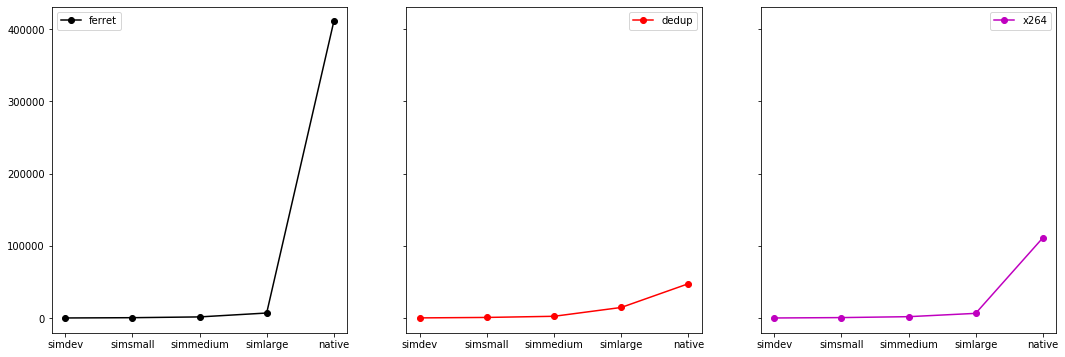

In [7]:
fig=plt.figure() #Creates a new figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axs[0].plot(c1data['input'].unique(),(c1data.loc[data['name'] == "ferret"])['real'],'ko-',label='ferret') #no need for str(x_axis)
axs[1].plot(c1data['input'].unique(),(c1data.loc[data['name'] == "dedup"])['real'],'ro-',label='dedup') 
axs[2].plot(c1data['input'].unique(),(c1data.loc[data['name'] == "x264"])['real'],'mo-',label='x264') 
axs[0].legend()
axs[1].legend()
axs[2].legend()

c1data['input'].unique()

#=======================================================================================================================================
#================ Chars for 3 benchmarks : native workload for gcc compiler configuration which is 1 thread and 1 core==================
#=======================================================================================================================================

# Statistical analysis for concurreny supportive compiler configurations

In [8]:
# Filtering parallel data 
parallelData = data.loc[(data['compiler'] != "gcc")]
parallelData = parallelData.drop(['id'],axis=1)

ferretData =parallelData.loc[(parallelData['name'] == "ferret")]
dedupData =parallelData.loc[(parallelData['name'] == "dedup")]
x264Data =parallelData.loc[(parallelData['name'] == "x264")]

# Input combinations in the dataset
inputCombinations = data['input'].unique()
# Thread combinations in the dataset    
threadCombinations = data['threads'].unique()
# cores combinations in the dataset
coresCombinations = data['cores'].unique()

#plots core
plt_coresCombinations = [1,2,4,8,16,32]

In [9]:
#  Drawing the matrix chart
def drawMatrixChartForInputs(x,data,axs,combinations,multiline,title,xlabel,ylabel,column='threads'):
    j=0
    for inputCombination in inputCombinations:
        y = data.loc[(data['input'] == inputCombination) ]
        y.head()
        minimum = min(y['real'])
        maximum = max(y['real'])
        i = 0
        for combination in combinations:
            axs[j][i].plot(x,(y.loc[y['threads'] == combination])['real'],label=(str(combination)+"-"+multiline),marker="o")
            axs[j][i].legend(loc=2)
            axs[j][i].set_xlabel('cores', fontsize=12)
            axs[j][i].set_ylabel('execution time', fontsize=12)
            axs[j][i].set_title(inputCombination, fontsize=14)
            axs[j][i].set_ylim(bottom=minimum,top=maximum)
            annot_max(x,(y.loc[y['threads'] == combination])['real'],axs[j,i])
            i = i +1
        j = j +1
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel(ylabel,fontsize=12)

#Drawing a single Chart
def drawChartForInputs(x,y,axs,combinations,multiline,title,xlabel,ylabel,column='threads'):
    plt.rcParams["figure.figsize"] = (20,20)
    for combination in combinations:
        plt.plot(x,(y.loc[y[column] == combination])['real'],label=(str(combination)+"-"+multiline),marker="o")
      

    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.title(title,fontsize=16)
    annot_max(x,(y.loc[y['threads'] == combination])['real'],plt)
    plt.legend(loc=2)

def annot_max(x,y, ax=None):
    xmin = data.iloc[y.idxmin].cores
    ymin = y.min()
    text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data',textcoords="axes fraction",
            bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.96), **kw)


## Analysis with threads and execution time for different number of cores

### Ferret Analysis

In [10]:
# phtread version
ferretPThreadData =ferretData.loc[ferretData['compiler'] == "gcc-pthreads"]

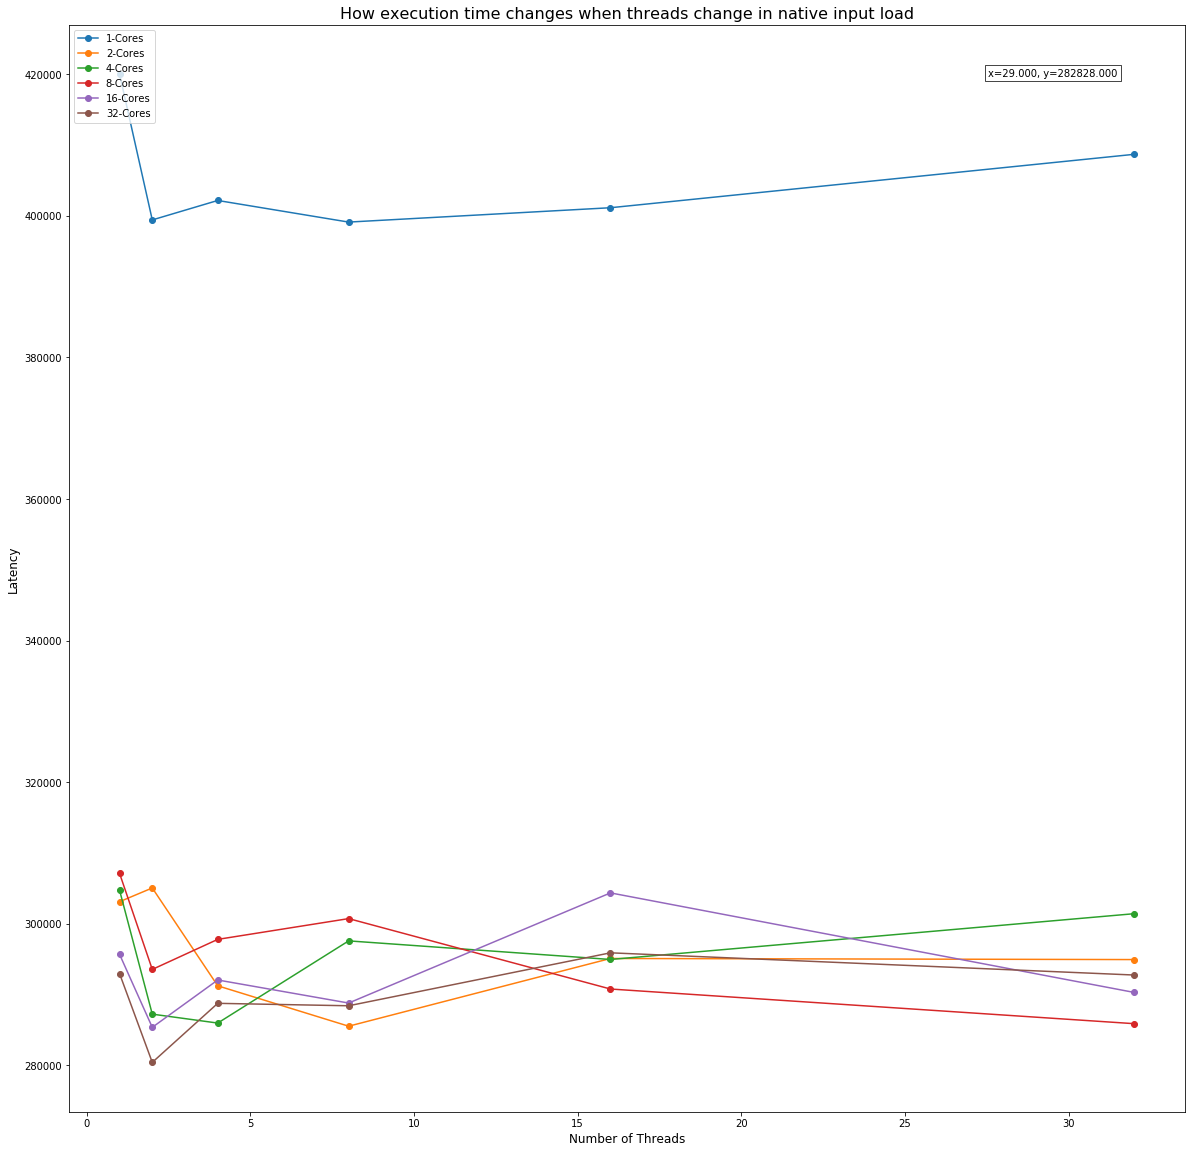

In [11]:
# Filtering for simdev
inputCombinationData = ferretPThreadData.loc[(ferretPThreadData['input'] == "native") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in native input load",'Number of Threads',"Latency",'cores')

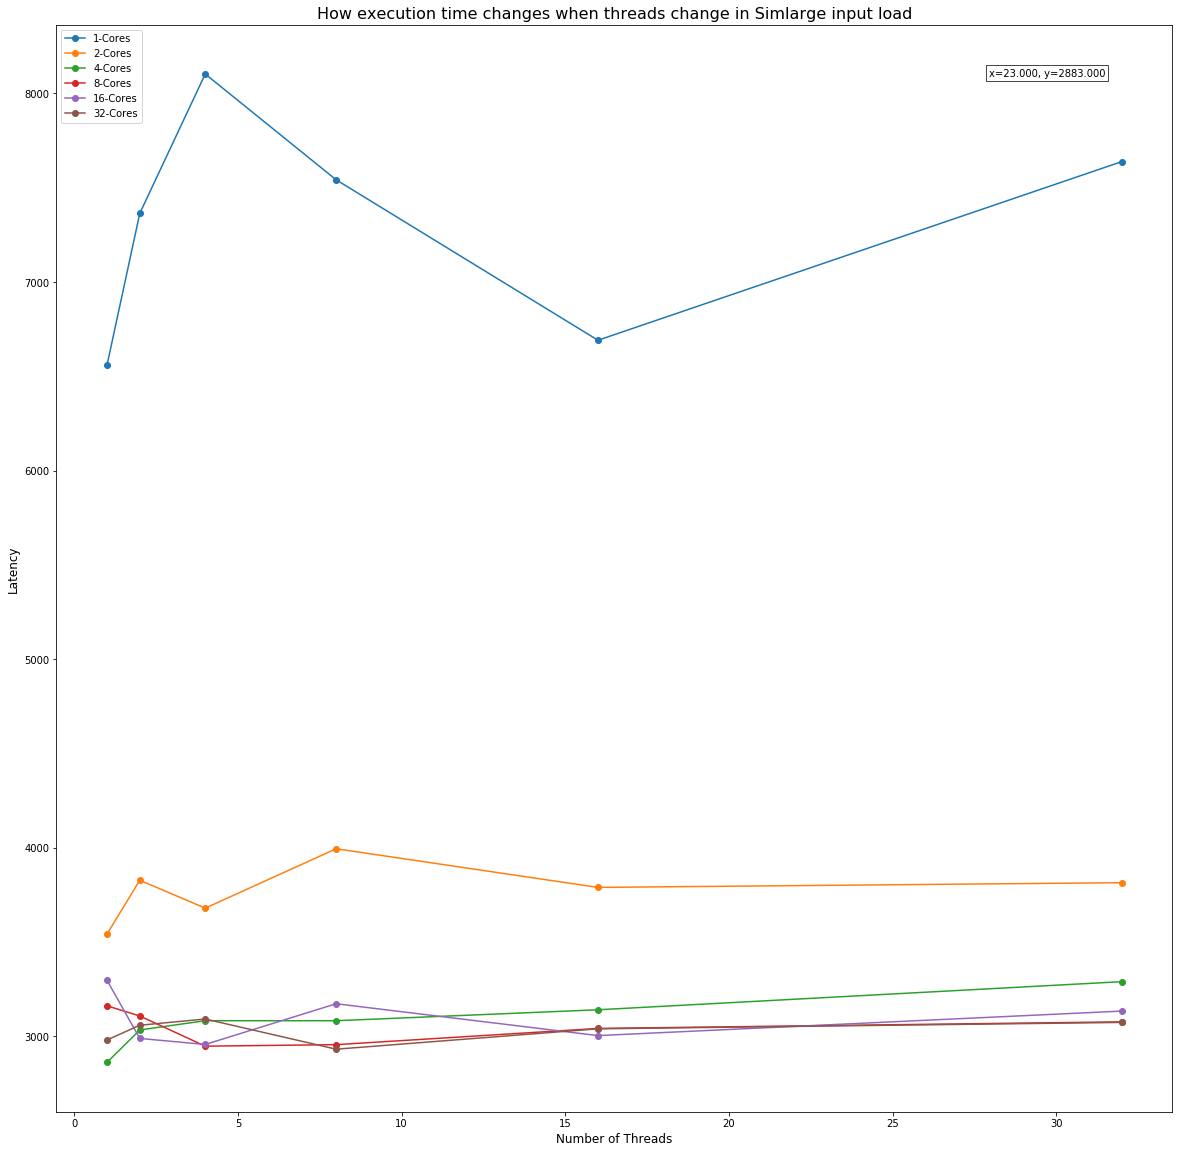

In [12]:
# Filtering for simdev
inputCombinationData = ferretPThreadData.loc[(ferretPThreadData['input'] == "simlarge") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in Simlarge input load",'Number of Threads',"Latency",'cores')

In [13]:
# gcc-tbb compiler configuration
ferretTBBData =ferretData.loc[ferretData['compiler'] == "gcc-tbb"]

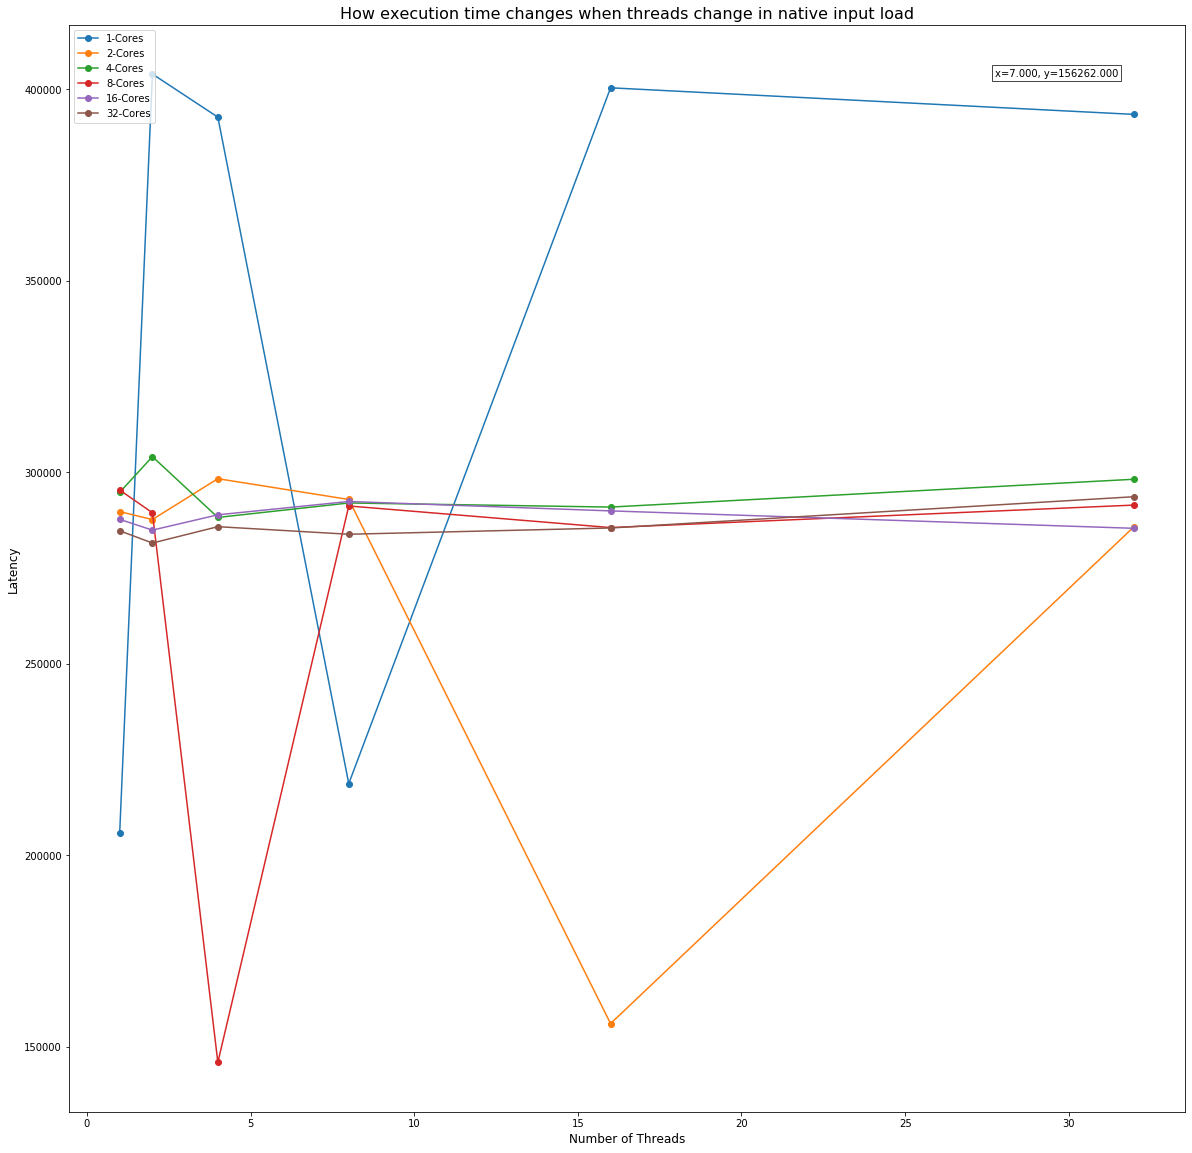

In [14]:
# Filtering for simdev
inputCombinationData = ferretTBBData.loc[(ferretTBBData['input'] == "native") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in native input load",'Number of Threads',"Latency",'cores')

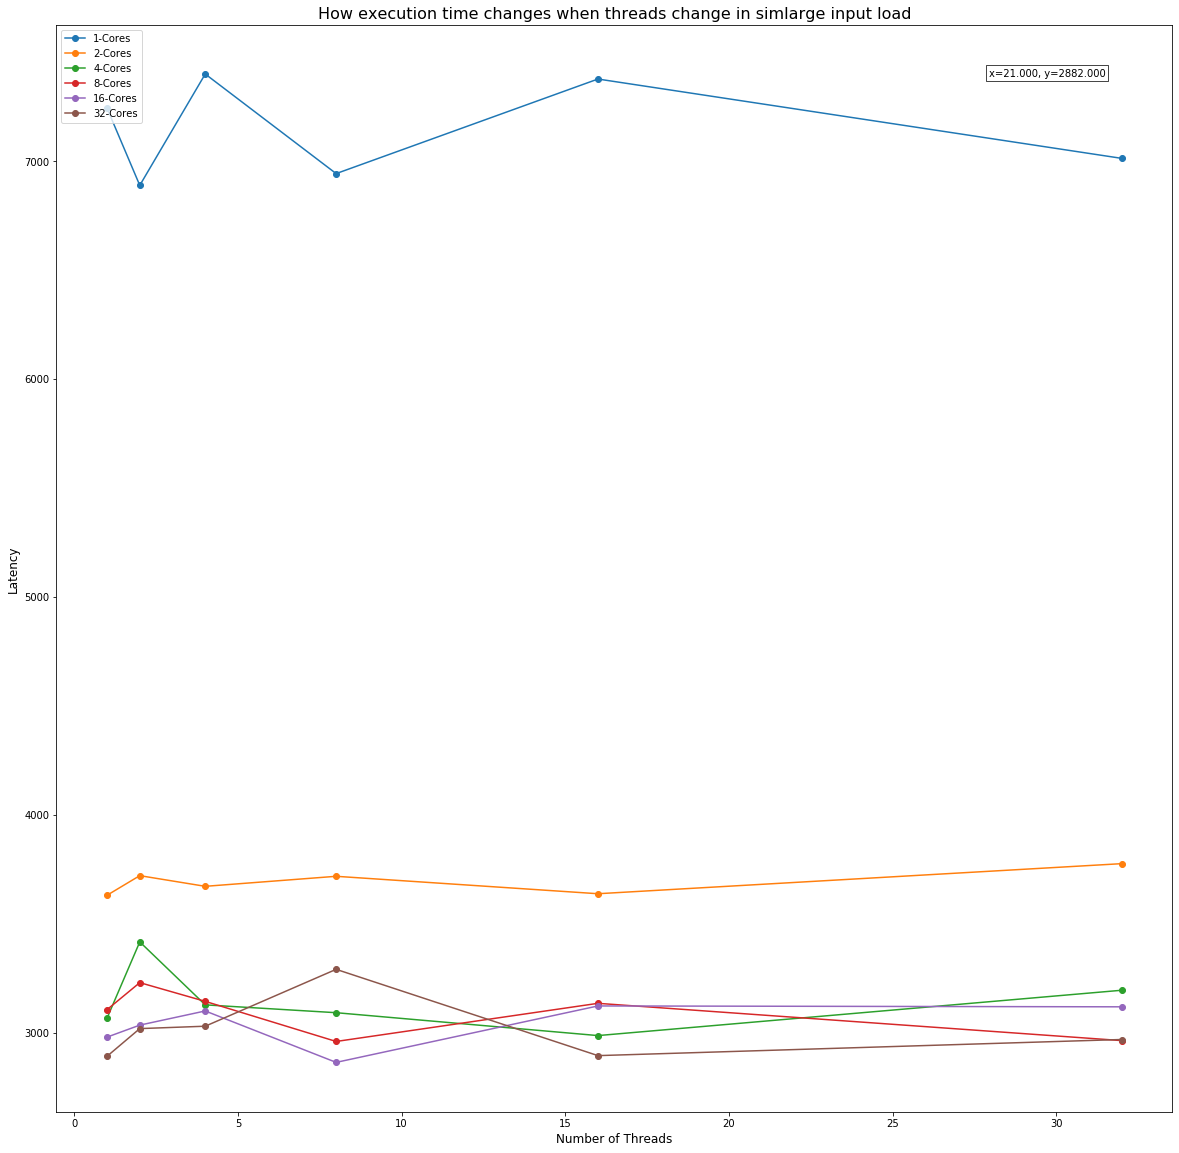

In [15]:
# Filtering for simdev
inputCombinationData = ferretTBBData.loc[(ferretTBBData['input'] == "simlarge") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in simlarge input load",'Number of Threads',"Latency",'cores')

### Dedup Analysis

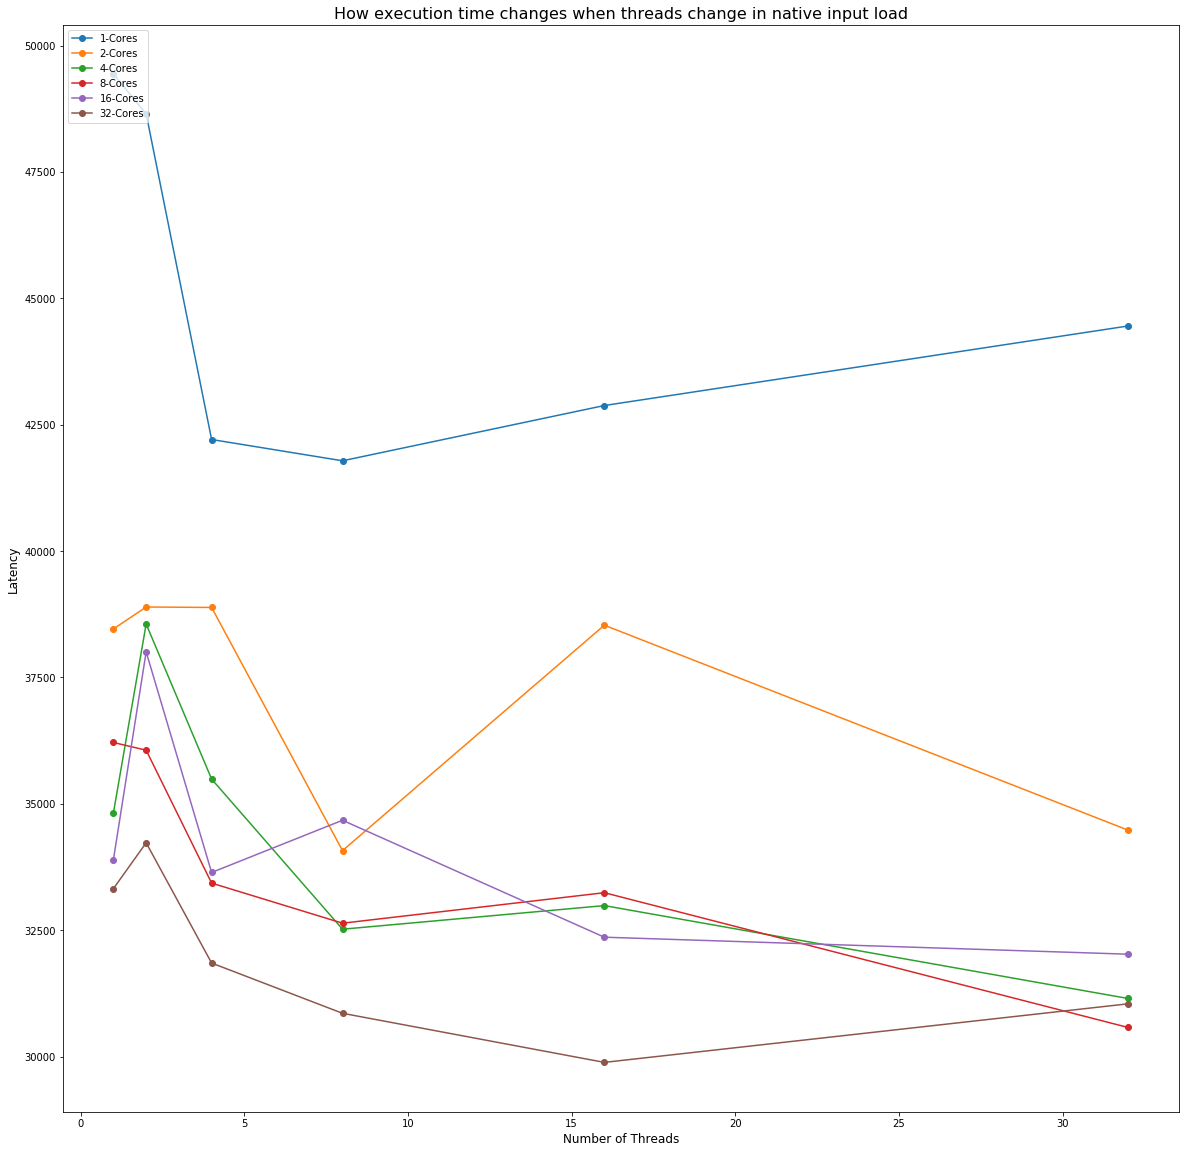

In [16]:
# Filtering for native
inputCombinationData = dedupData.loc[(dedupData['input'] == "native") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in native input load",'Number of Threads',"Latency",'cores')

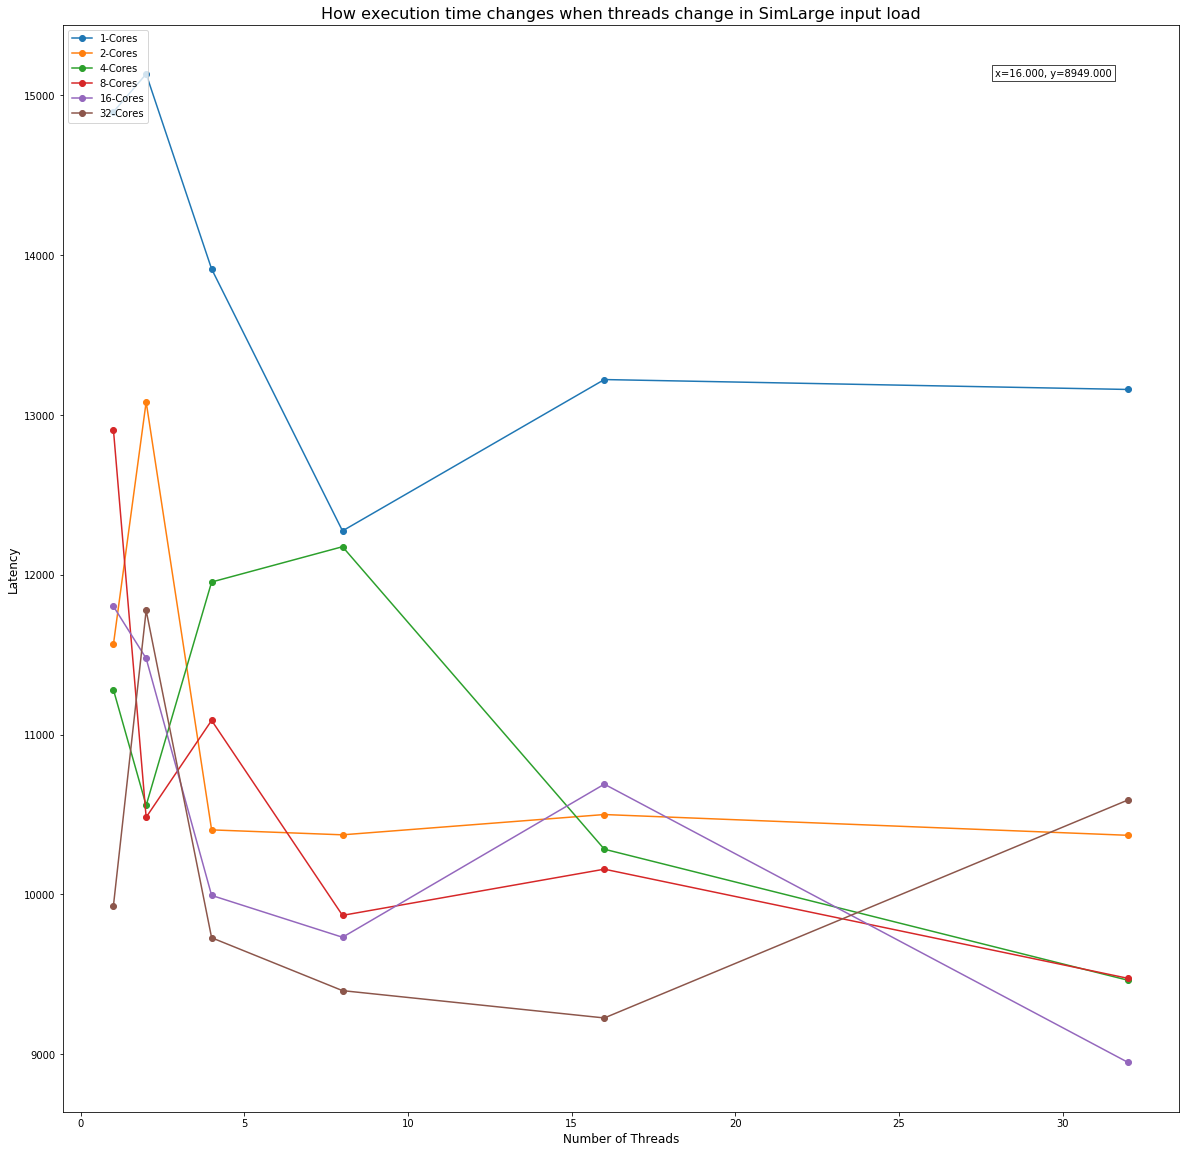

In [17]:
# Filtering for native
inputCombinationData = dedupData.loc[(dedupData['input'] == "simlarge") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in SimLarge input load",'Number of Threads',"Latency",'cores')

### x264 Analysis

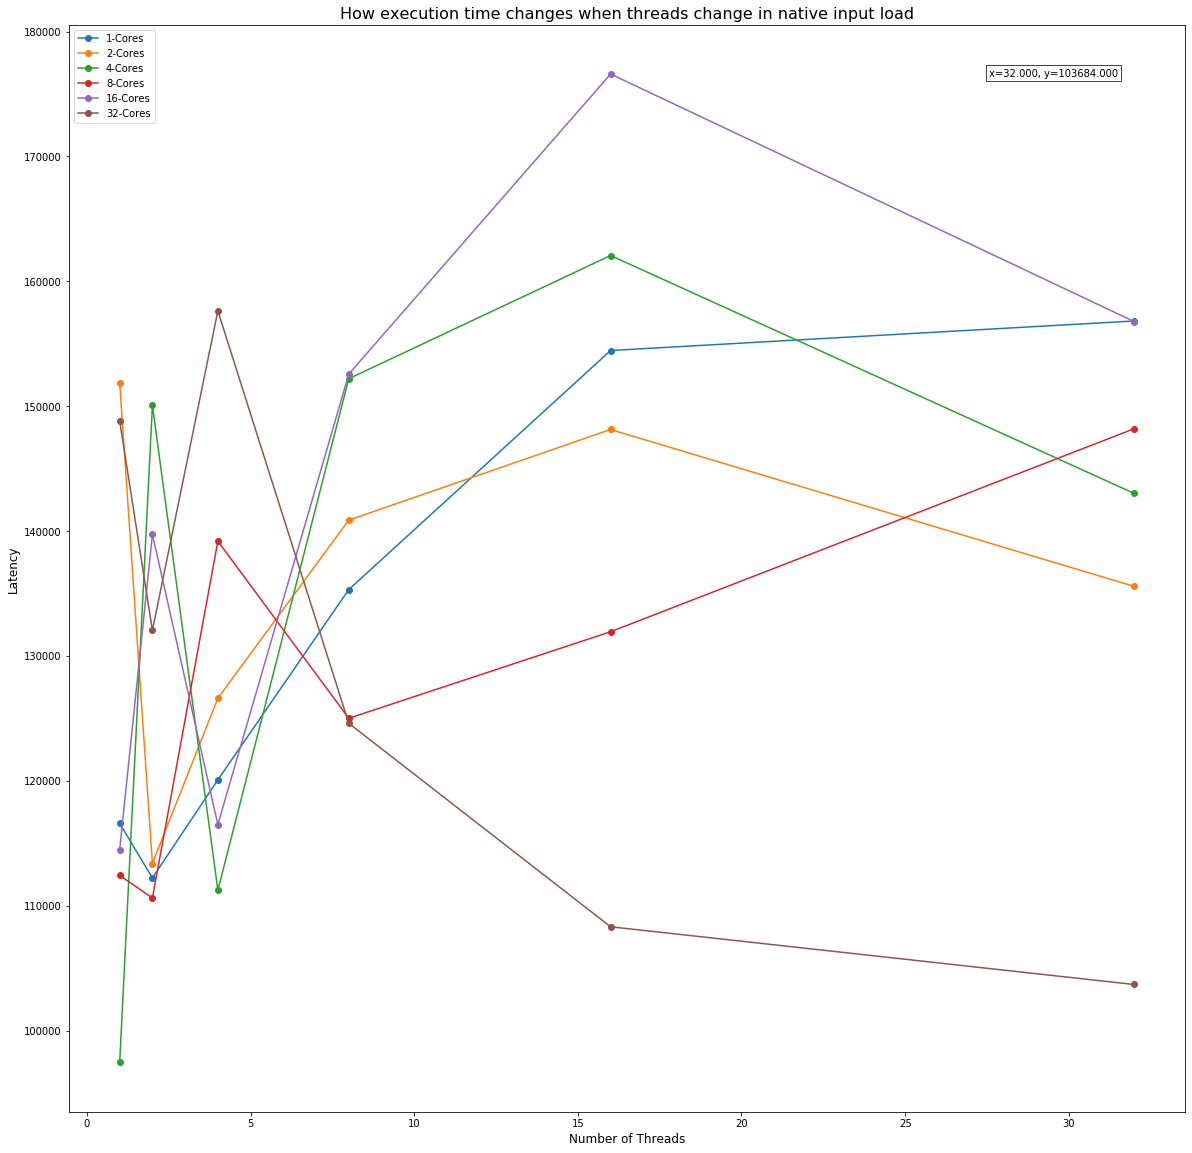

In [18]:
# Filtering for native
inputCombinationData = x264Data.loc[(x264Data['input'] == "native") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in native input load",'Number of Threads',"Latency",'cores')

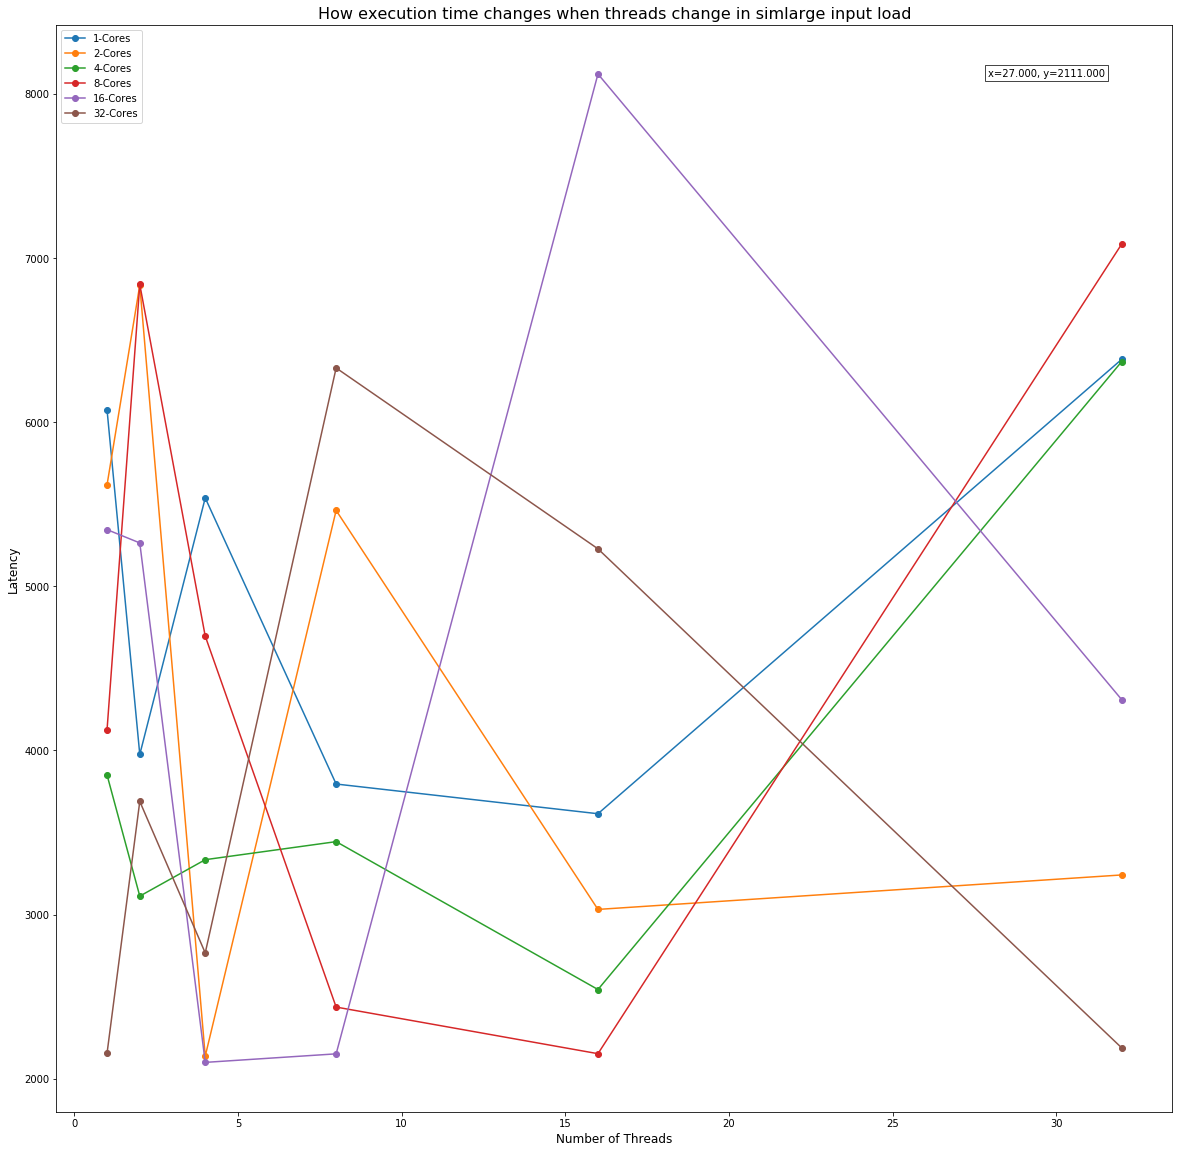

In [19]:
# Filtering for native
inputCombinationData = x264Data.loc[(x264Data['input'] == "simlarge") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in simlarge input load",'Number of Threads',"Latency",'cores')

## Analysis with cores and execution time for different number of threads

### Ferret Analysis

In [20]:
# phtread version
ferretPThreadData =ferretData.loc[ferretData['compiler'] == "gcc-pthreads"]


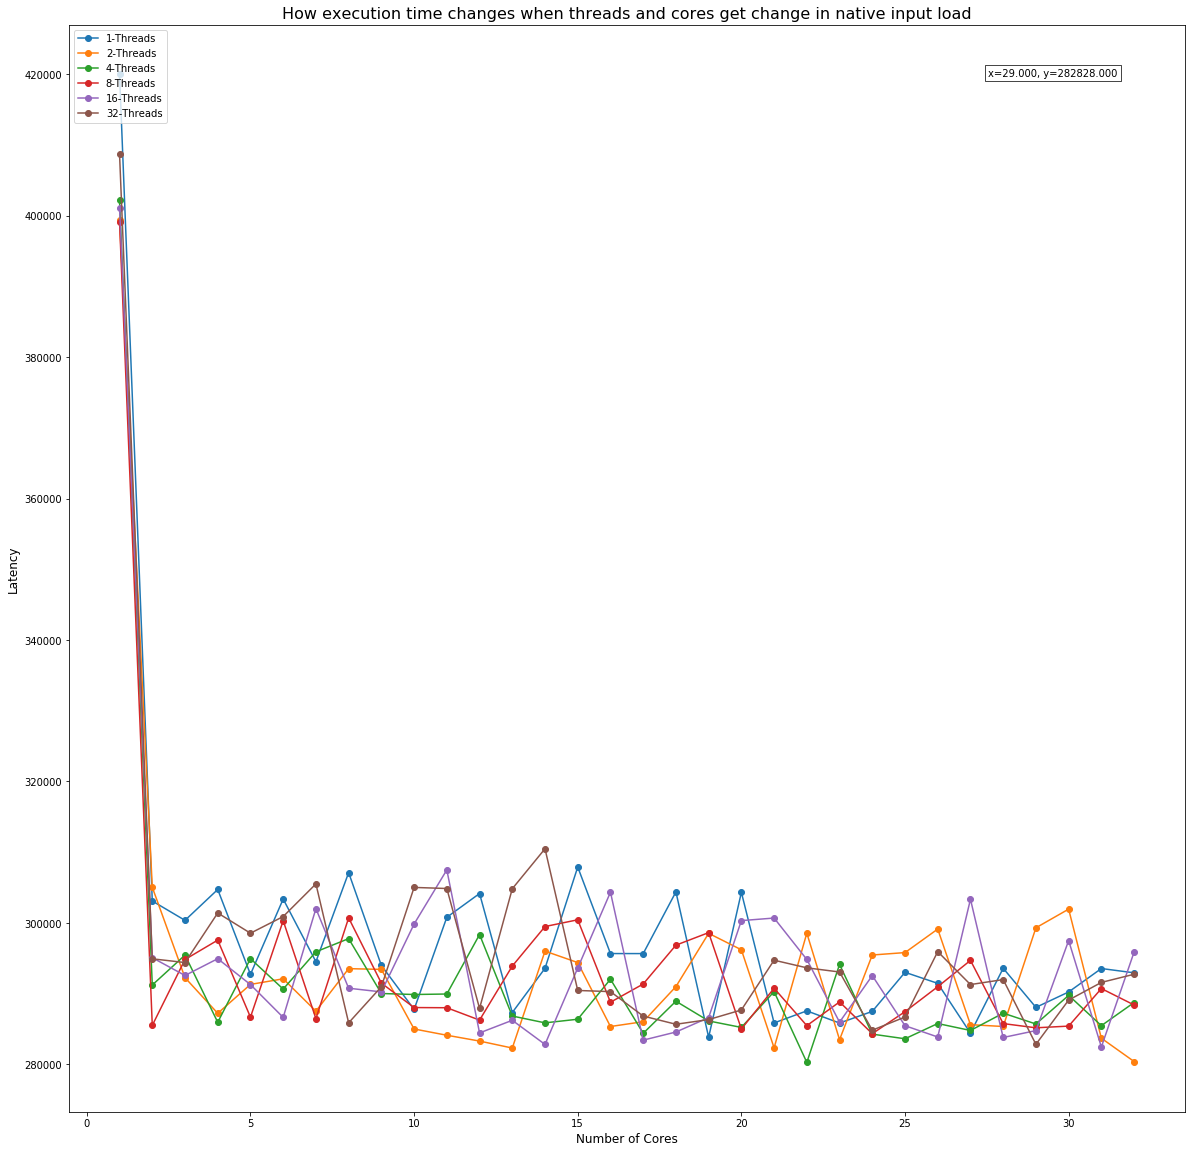

In [21]:
# Filtering for simdev
inputCombinationData = ferretPThreadData.loc[(ferretPThreadData['input'] == "native") ]
drawChartForInputs(coresCombinations,inputCombinationData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change in native input load",'Number of Cores',"Latency")

<Figure size 1440x1440 with 0 Axes>

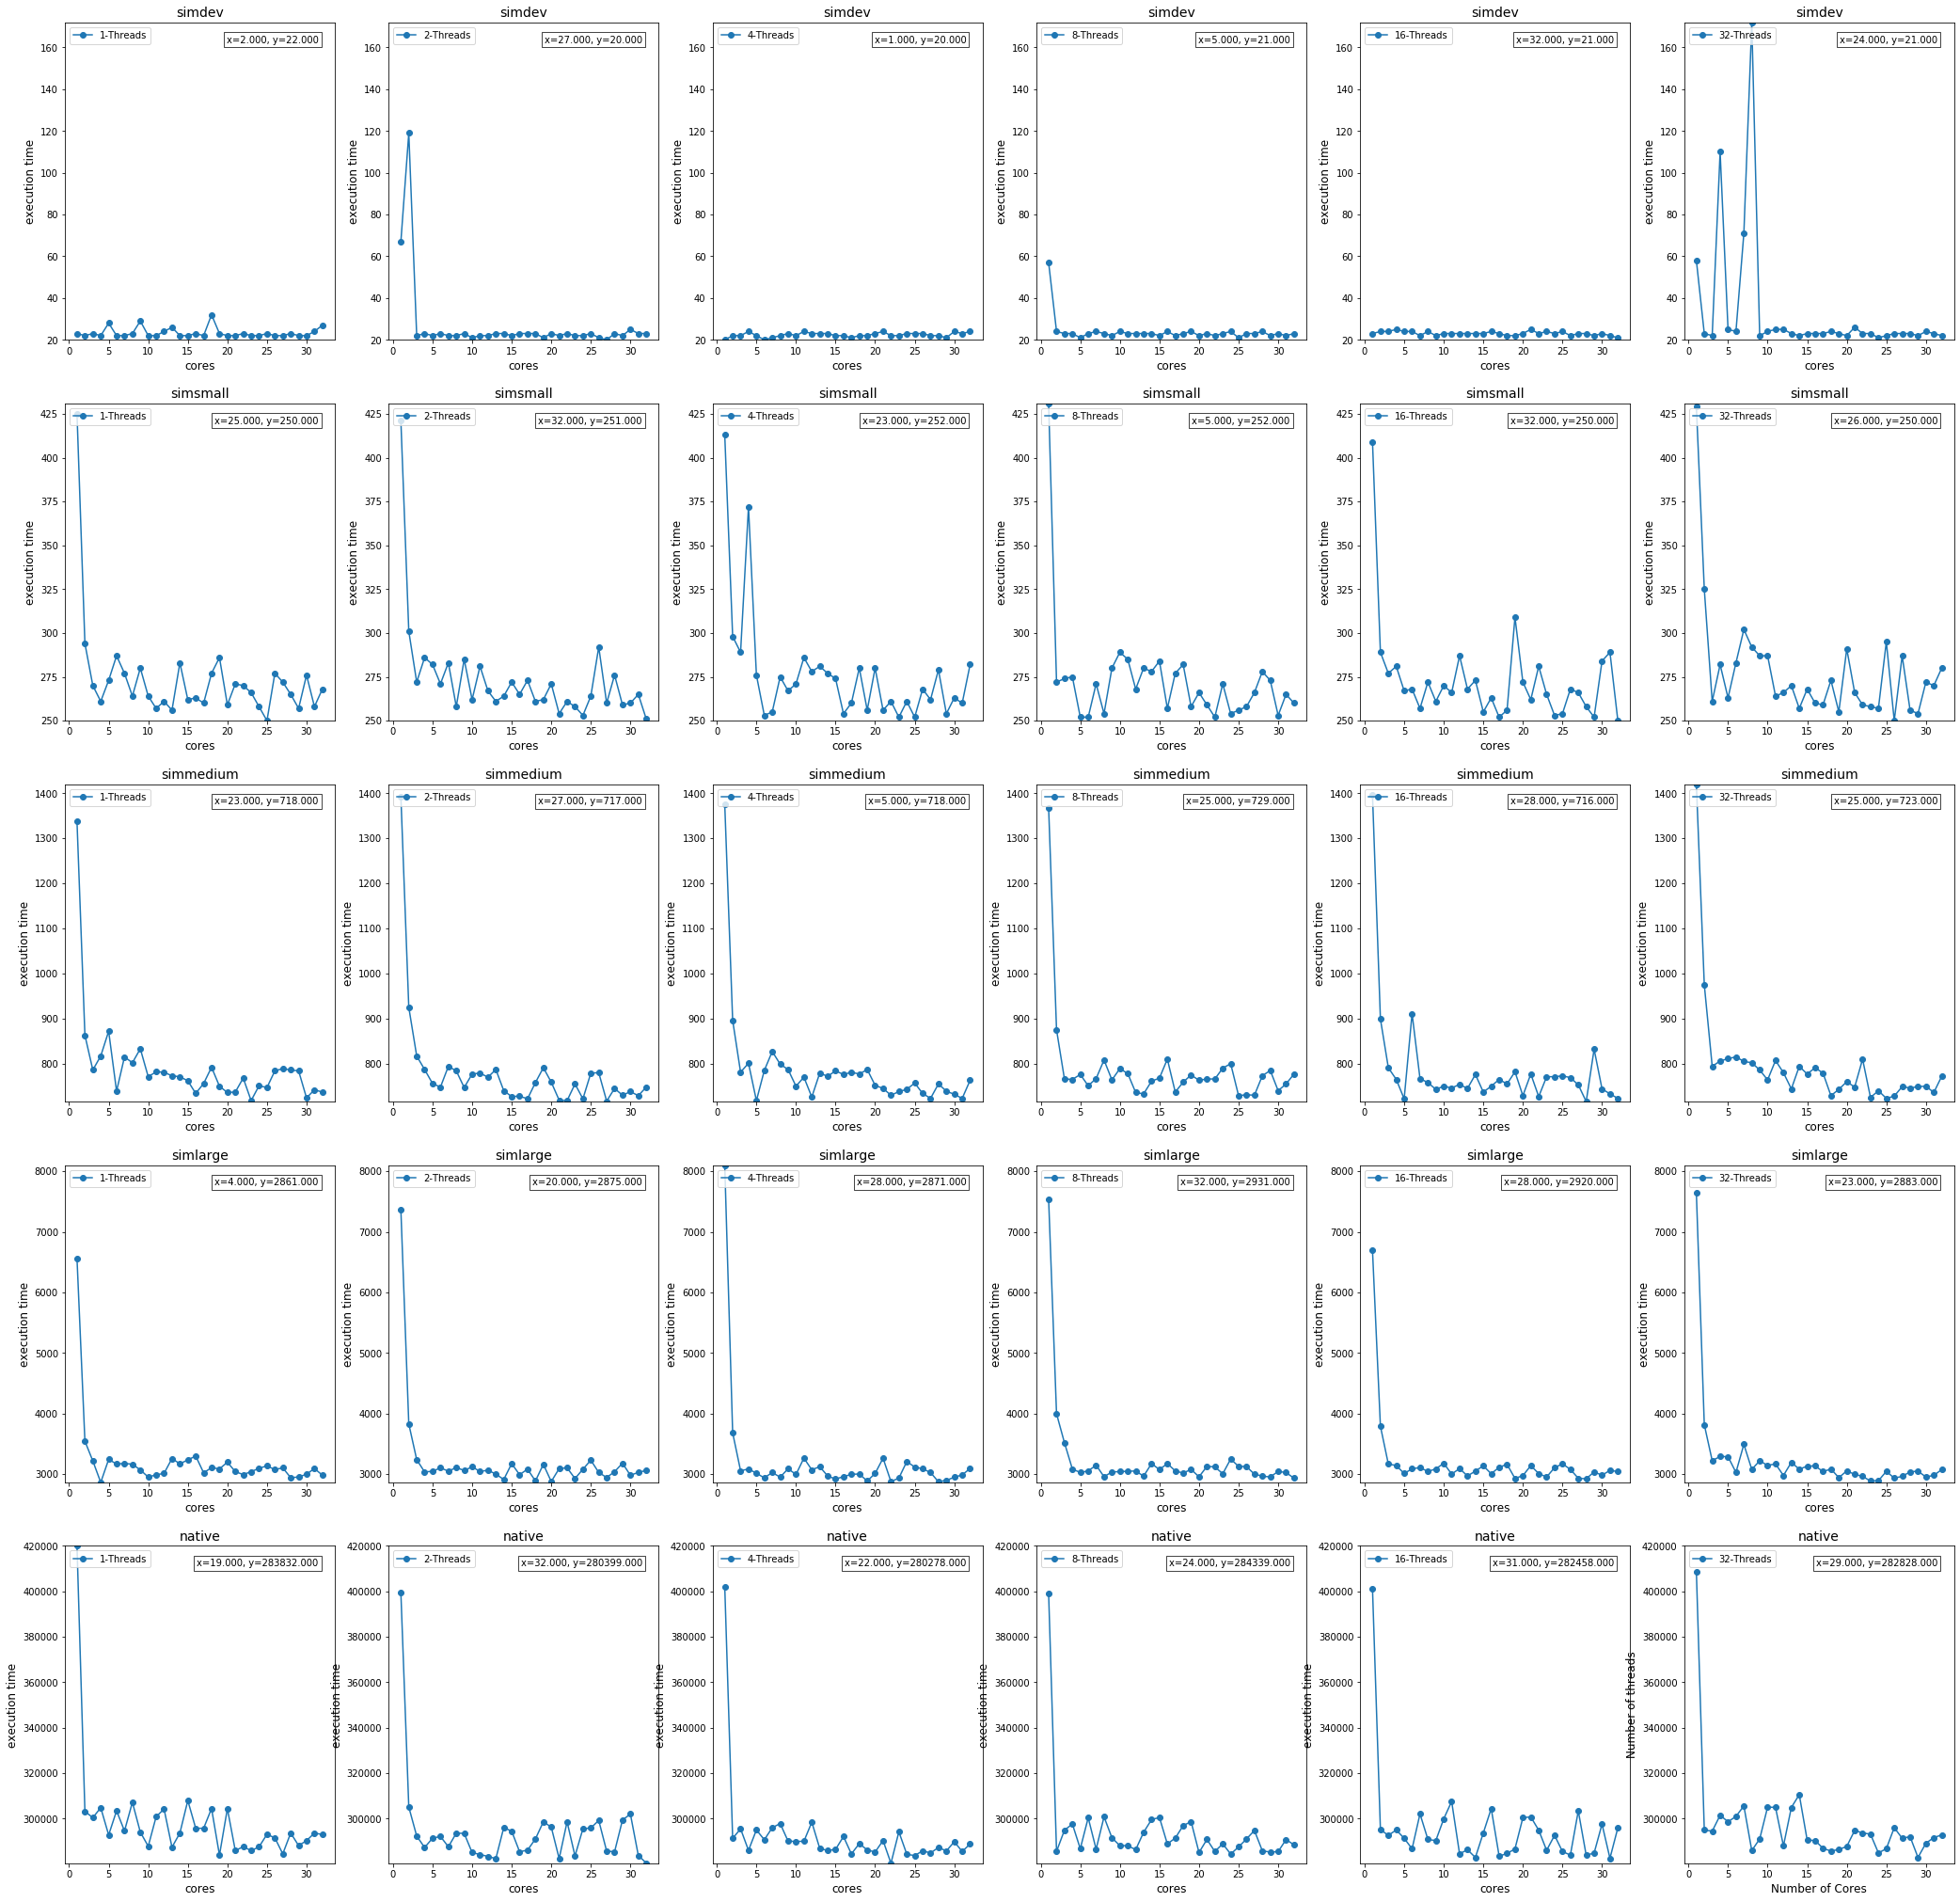

In [22]:
fig=plt.figure() #Creates a new figure
fig, axs = plt.subplots(5,6, figsize=(36, 36))
drawMatrixChartForInputs(coresCombinations,ferretPThreadData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change",'Number of Cores',"Number of threads")

In [23]:
# gcc-tbb compiler configuration
ferretTBBData =ferretData.loc[ferretData['compiler'] == "gcc-tbb"]

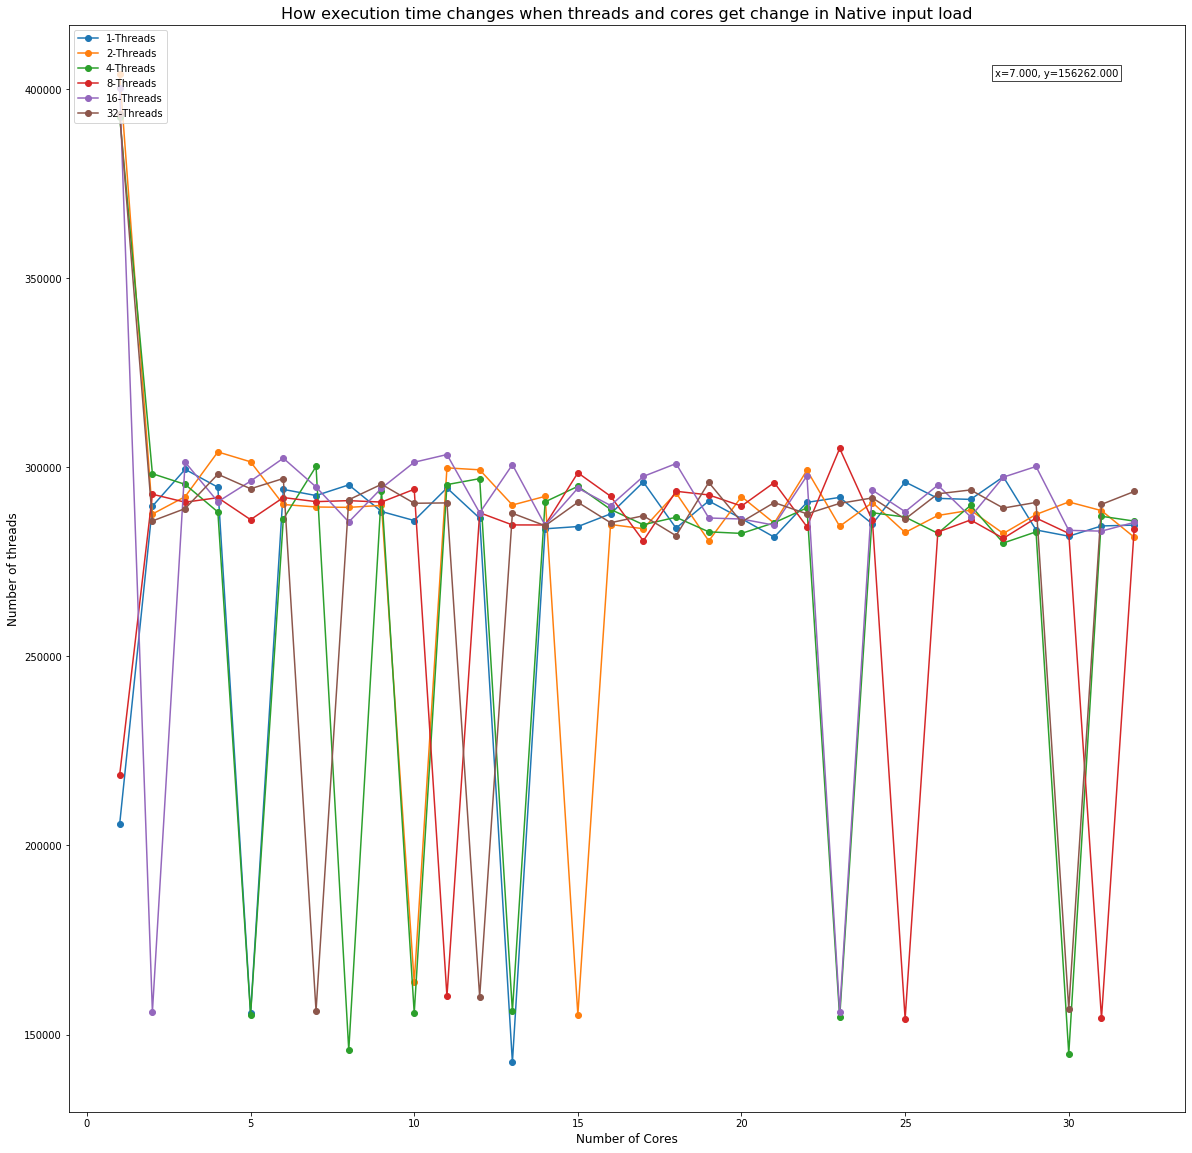

In [24]:
# Filtering for simdev
inputCombinationData = ferretTBBData.loc[(ferretTBBData['input'] == "native") ]

drawChartForInputs(coresCombinations,inputCombinationData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change in Native input load",'Number of Cores',"Number of threads")

<Figure size 1440x1440 with 0 Axes>

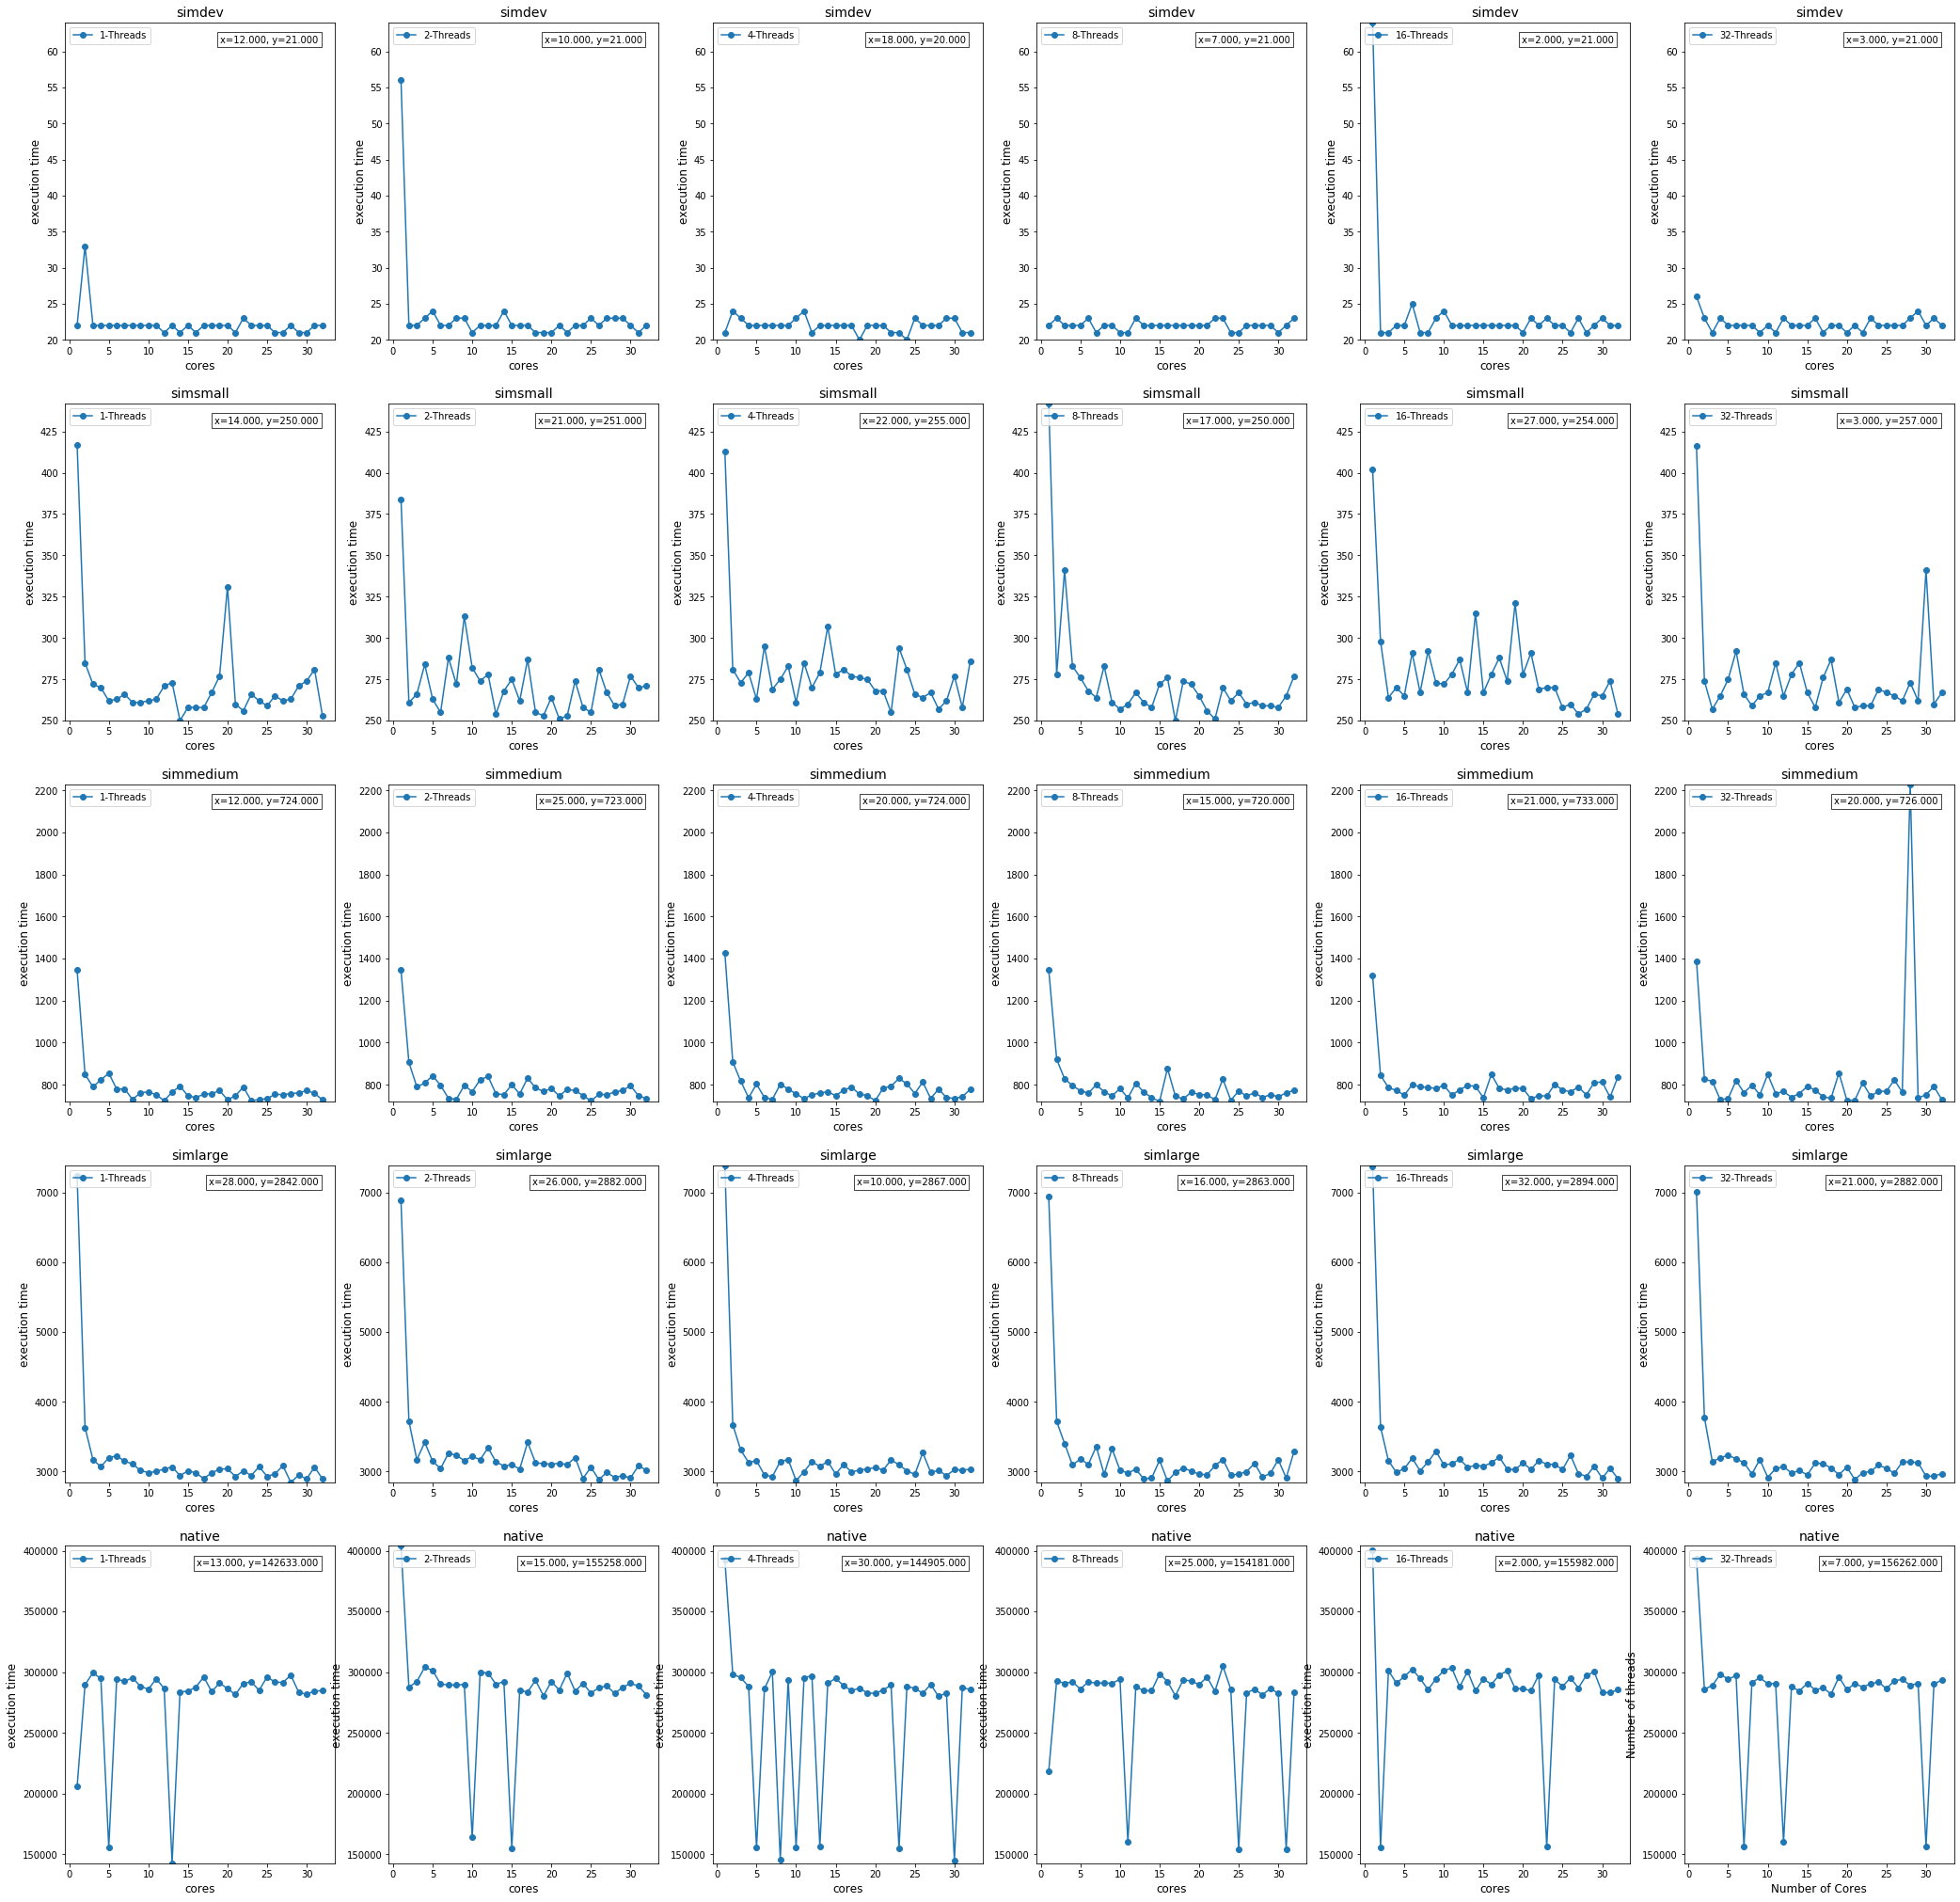

In [25]:
fig=plt.figure() #Creates a new figure
fig, axs = plt.subplots(5,6, figsize=(36, 36))
drawMatrixChartForInputs(coresCombinations,ferretTBBData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change",'Number of Cores',"Number of threads")

# Dedup Analysis

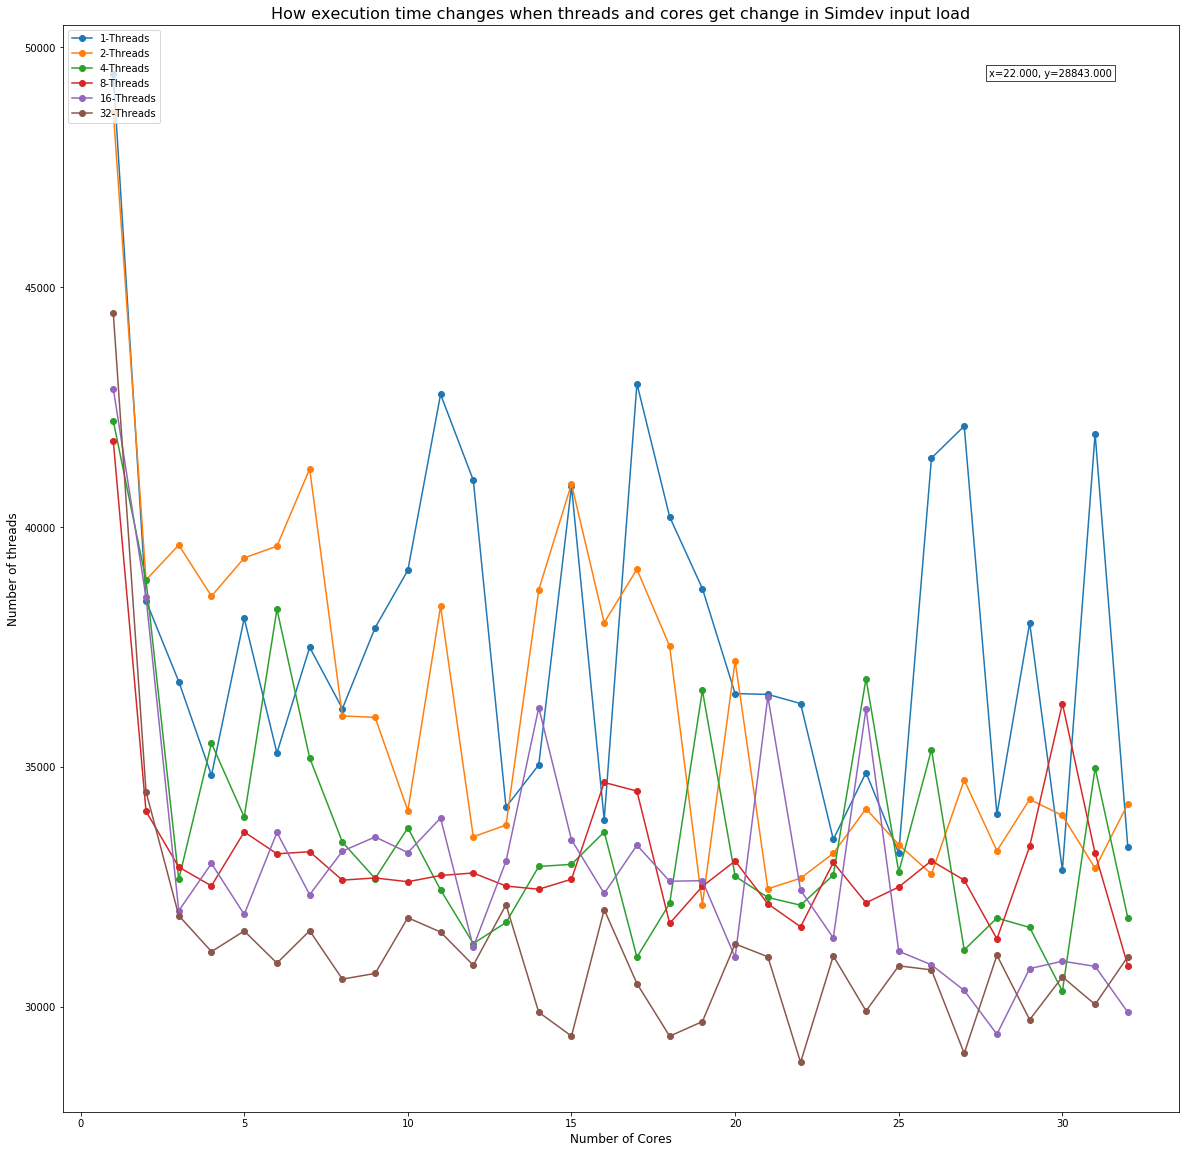

In [26]:
# Filtering for native
inputCombinationData = dedupData.loc[(dedupData['input'] == "native") ]
drawChartForInputs(coresCombinations,inputCombinationData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change in Simdev input load",'Number of Cores',"Number of threads")

<Figure size 1440x1440 with 0 Axes>

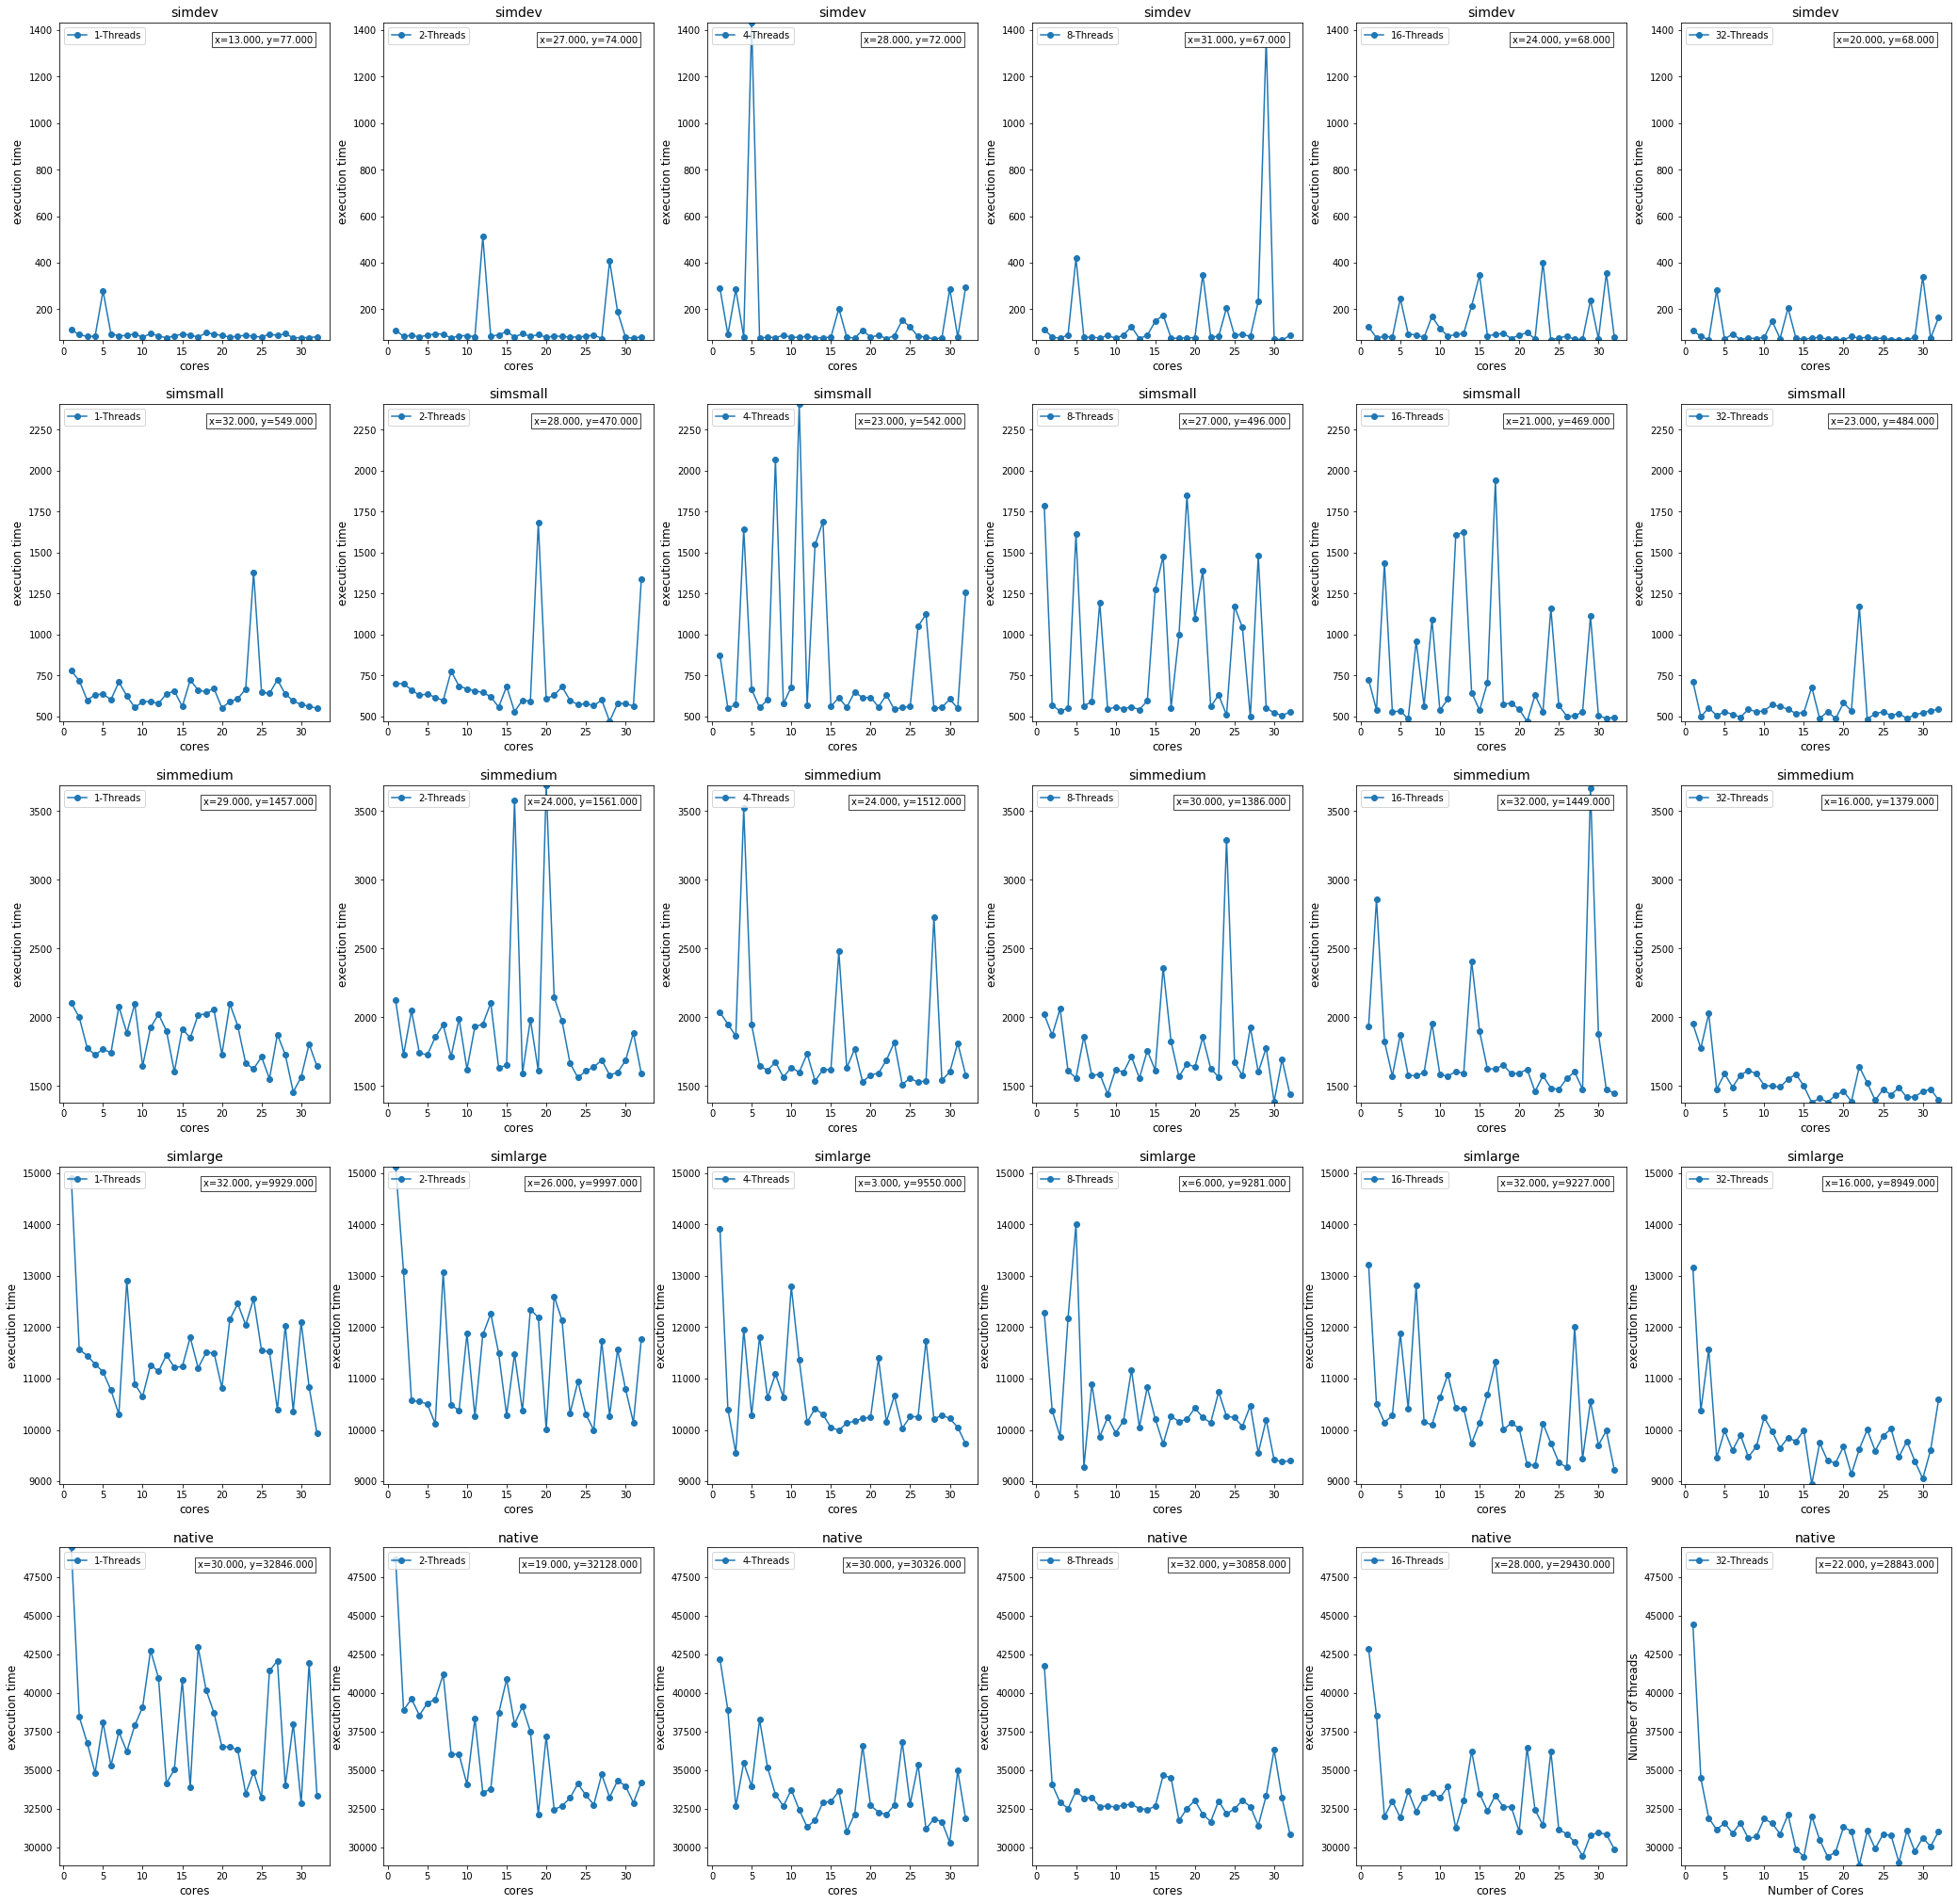

In [27]:
fig=plt.figure() #Creates a new figure
fig, axs = plt.subplots(5,6, figsize=(36, 36))
drawMatrixChartForInputs(coresCombinations,dedupData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change",'Number of Cores',"Number of threads")

# x264 Analysis

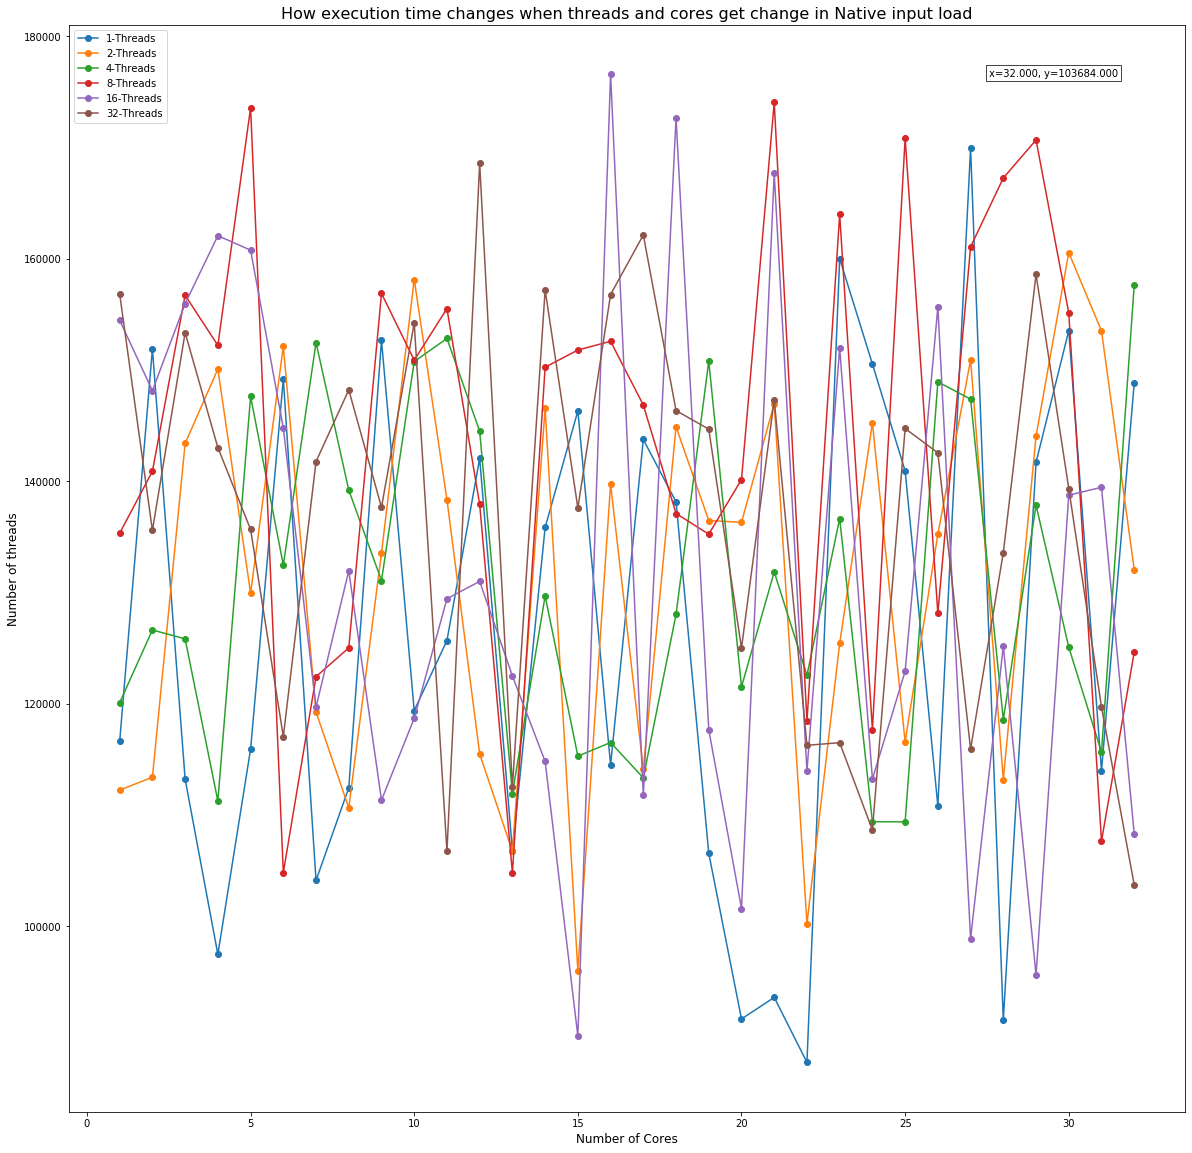

In [28]:
# Filtering for native
inputCombinationData = x264Data.loc[(x264Data['input'] == "native") ]
drawChartForInputs(coresCombinations,inputCombinationData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change in Native input load",'Number of Cores',"Number of threads")

<Figure size 1440x1440 with 0 Axes>

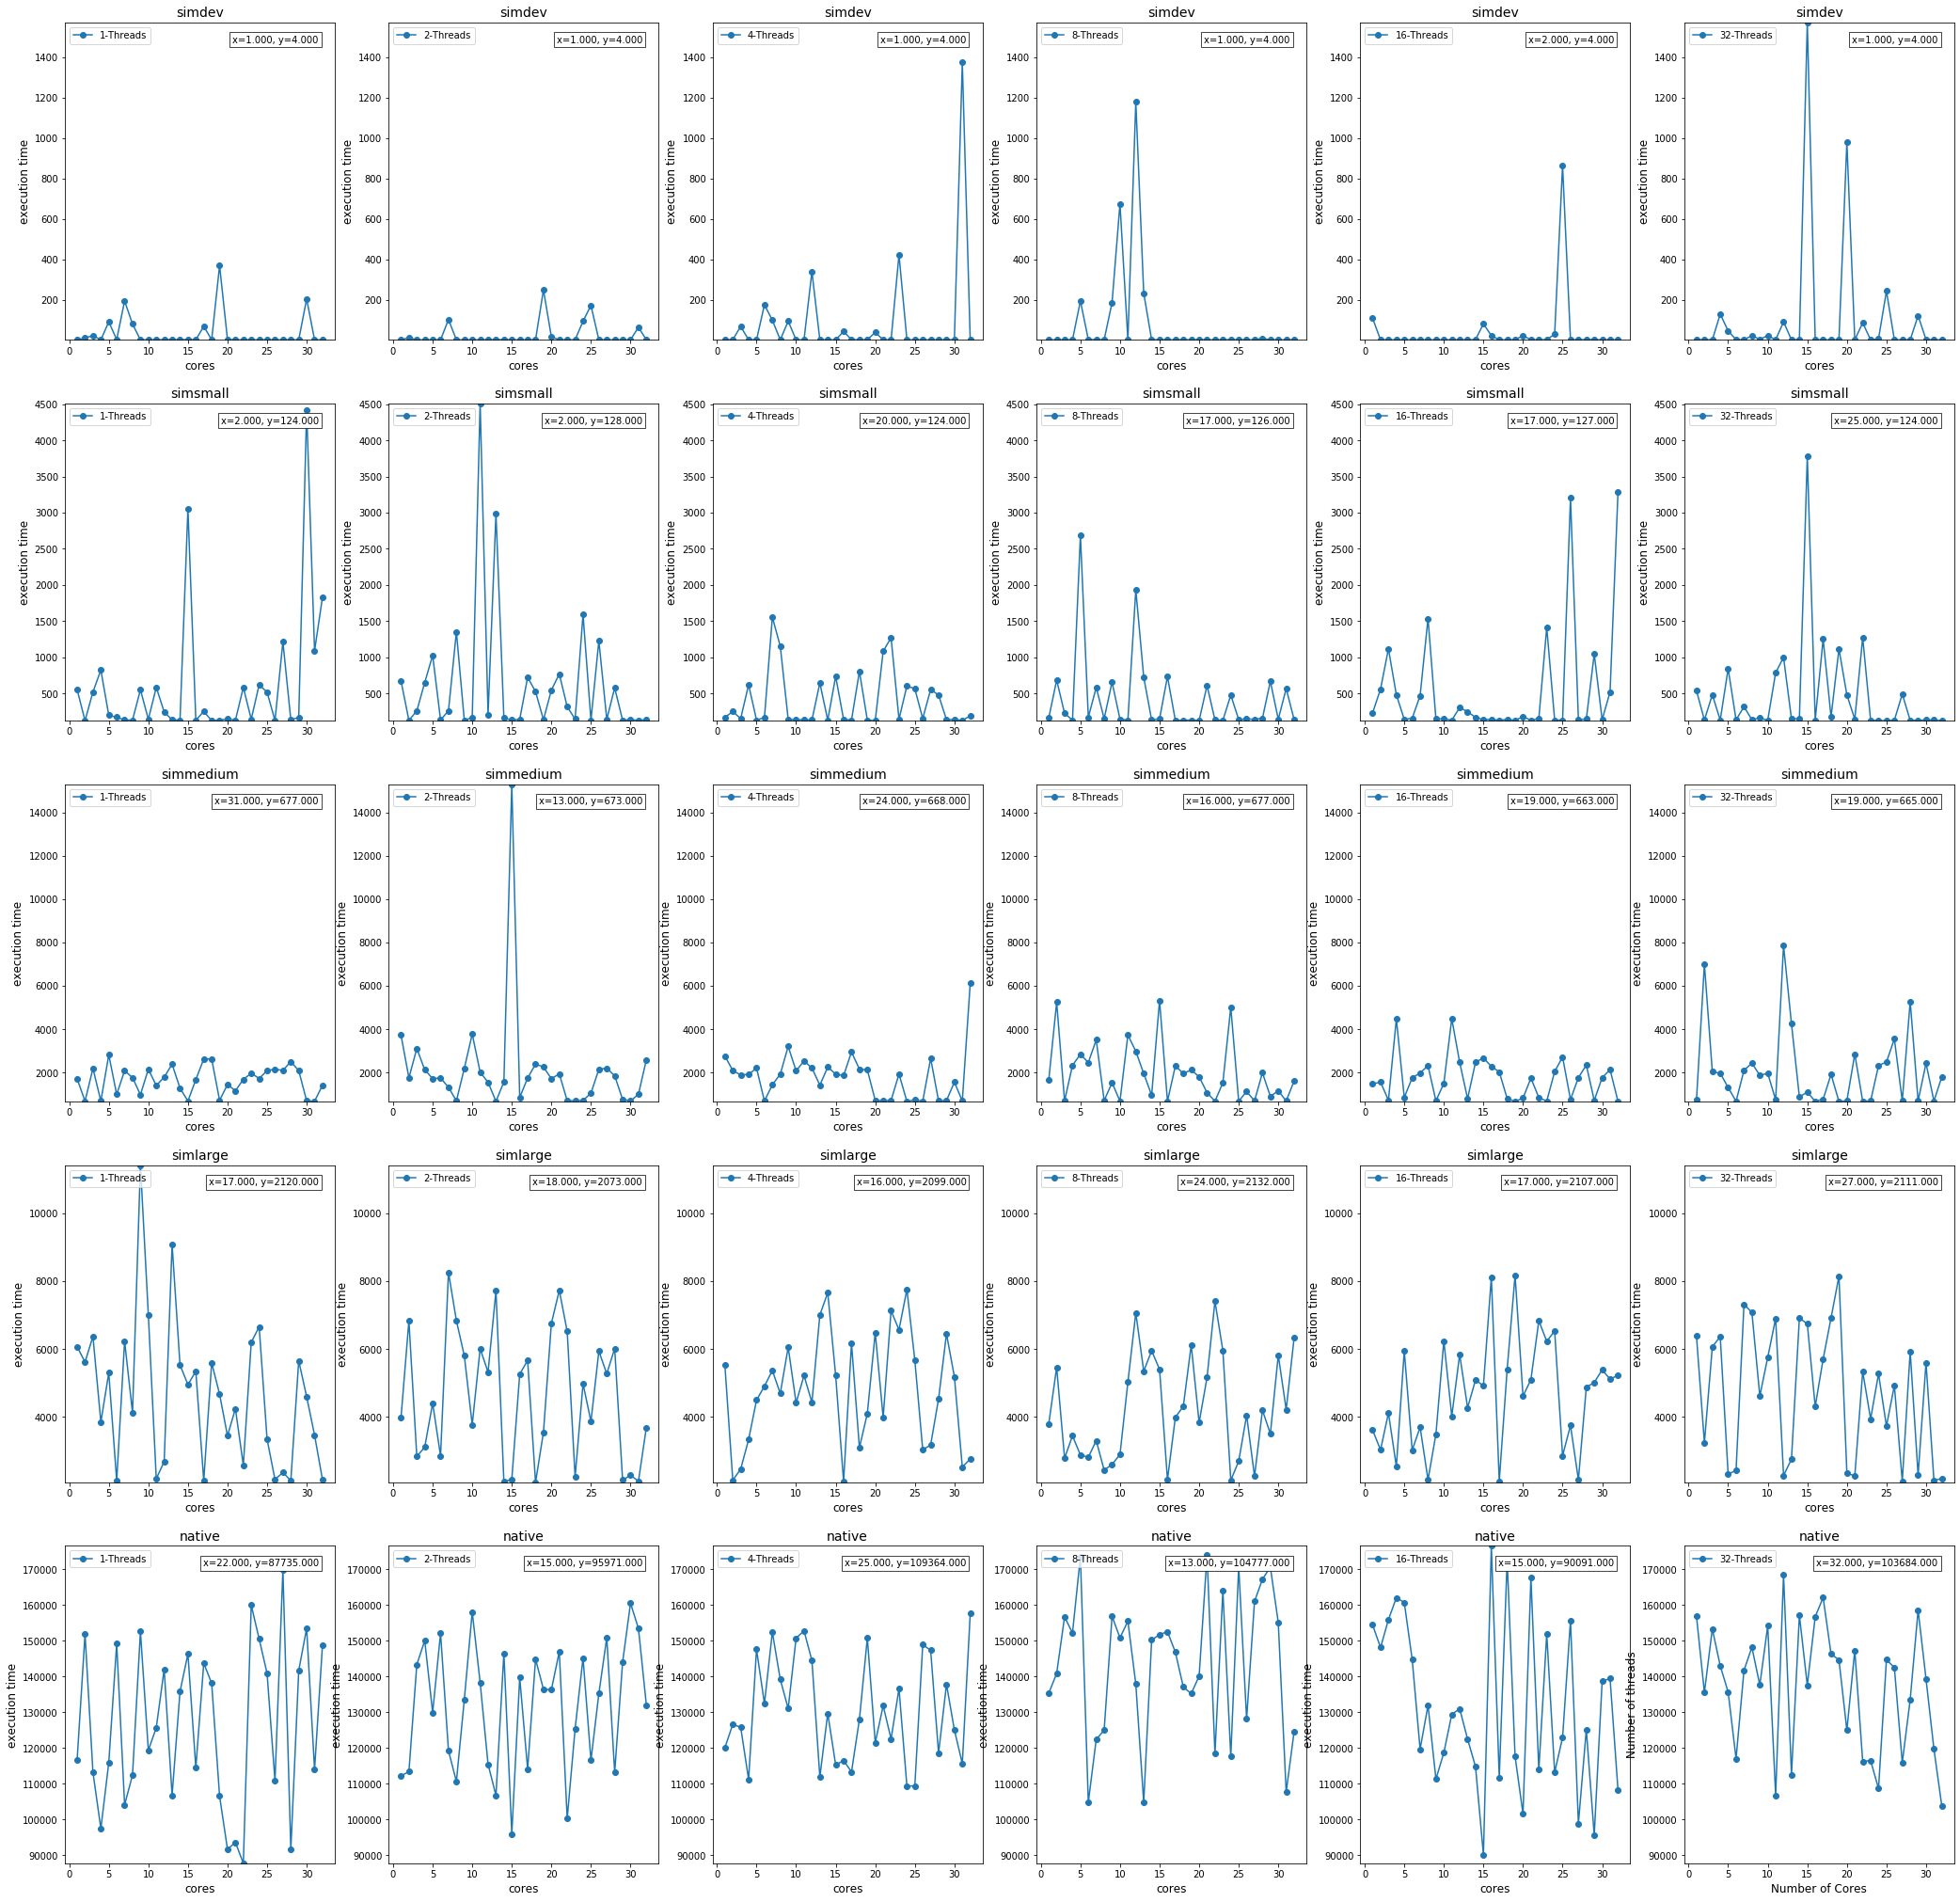

In [29]:
fig=plt.figure() #Creates a new figure
fig, axs = plt.subplots(5,6, figsize=(36, 36))
drawMatrixChartForInputs(coresCombinations,x264Data,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change",'Number of Cores',"Number of threads")

## Pair Plots for Dataset

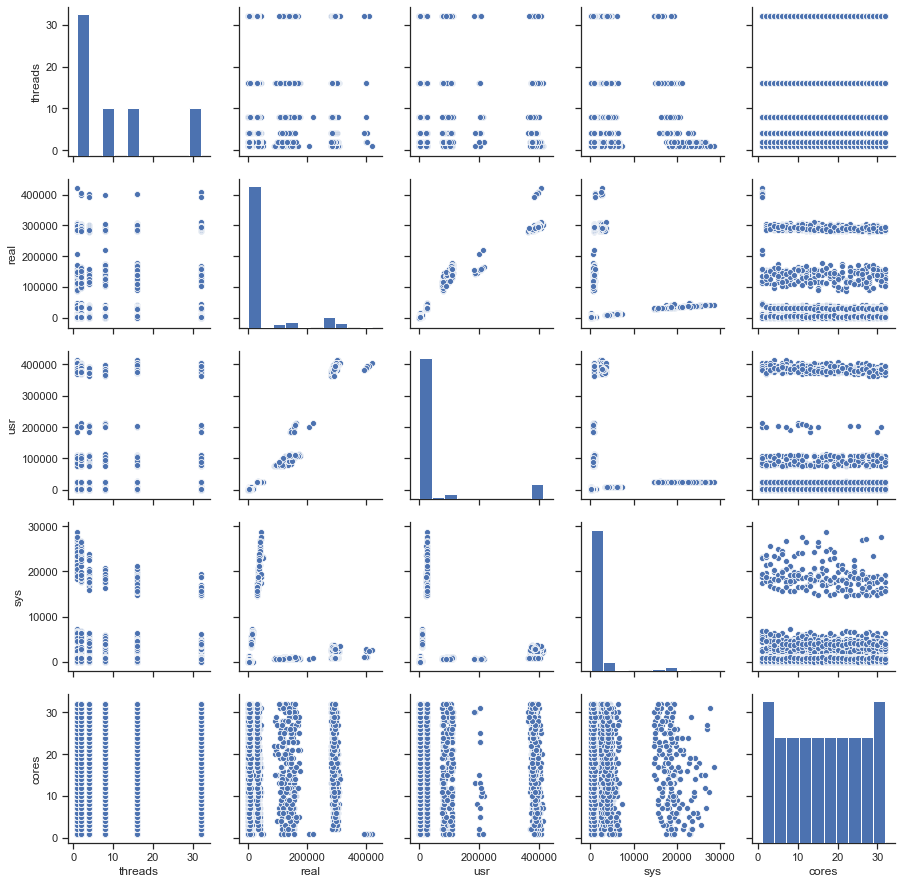

In [30]:
# Creating pair plot
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(parallelData)

# Machine Learning Models

#### MAPE definition


In [68]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Evaluate Model metrics and return predictions
def evaluateModel(model,X_train,Y_train,X_test,Y_test,nameTrain,nameTest):
    model.fit(X_train,Y_train)
    
    #Print MAE
    mae = mean_absolute_error(Y_train, model.predict(X_train))
    statistics[nameTrain].MAE = mae
    print("MAE-train",mae)
    mae = mean_absolute_error(Y_test, model.predict(X_test))
    statistics[nameTest].MAE = mae
    print("MAE-test",mae)

    #Print MAPE
    mape = mean_absolute_percentage_error(Y_train, model.predict(X_train))
    statistics[nameTrain].MAPE = mape
    print("MAPE-train",mape)
    mape = mean_absolute_percentage_error(Y_test, model.predict(X_test))
    statistics[nameTest].MAPE = mape
    print("MAPE-test",mape)


    #Print MSE
    mse = mean_squared_error(Y_train, model.predict(X_train))
    statistics[nameTrain].MSE = mse
    print("MSE-train",mse)
    mse = mean_squared_error(Y_test, model.predict(X_test))
    statistics[nameTest].MSE = mse
    print("MSE-test",mse)

    
    #Print RMSE
    rmse = math.sqrt(mean_squared_error(Y_train, model.predict(X_train)))
    statistics[nameTrain].RMSE = rmse
    print("RMSE-train",rmse)
    rmse = math.sqrt(mean_squared_error(Y_test, model.predict(X_test)))
    statistics[nameTest].RMSE = rmse
    print("RMSE-test",rmse)
    
    return model.predict(X_test)

## Data preprocessing

In [31]:
columns = ['name','input','compiler','threads','cores','real']
parallelData = parallelData[columns]


### Transforming categorical columns using dummies

In [32]:
parallelData = pd.get_dummies(parallelData)

In [33]:
y_data = parallelData.iloc[:,2:3]
x_data = parallelData.drop(['real'],axis=1)

### Splitting the data

In [34]:

# Splitting the data set into training : 20% and testing : 80% beacuse the dataset has covered the all the combinational space
X_train_2080,X_test_2080,Y_train_2080,Y_test_2080 = train_test_split(x_data,y_data,shuffle=True,train_size=0.2)

### Statistics for 20% train 80% test split

In [57]:
statisticsReocrds = {
    'XGBRegressor(20-80)train':[ 0.0, 0.0, 0.0,0.0],
    'XGBRegressor(20-80)test':[ 0.0, 0.0, 0.0,0.0],
    'XGBRegressor(80-20)train':[ 0.0, 0.0, 0.0,0.0],
    'XGBRegressor(80-20)test':[ 0.0, 0.0, 0.0,0.0],
    'RandomForrest(20-80)train':[ 0.0, 0.0, 0.0,0.0],
    'RandomForrest(20-80)test':[ 0.0, 0.0, 0.0,0.0],
    'RandomForrest(80-20)train':[ 0.0, 0.0, 0.0,0.0],
    'RandomForrest(80-20)test':[ 0.0, 0.0, 0.0,0.0]
}
  
# Creates pandas DataFrame. 
statistics = pd.DataFrame(statisticsReocrds, index =['MAE', 'MAPE', 'MSE','RMSE']) 
statistics

XGBRegressor(20-80)train  XGBRegressor(20-80)test  \
MAE                        0.0                      0.0   
MAPE                       0.0                      0.0   
MSE                        0.0                      0.0   
RMSE                       0.0                      0.0   

      XGBRegressor(80-20)train  XGBRegressor(80-20)test  \
MAE                        0.0                      0.0   
MAPE                       0.0                      0.0   
MSE                        0.0                      0.0   
RMSE                       0.0                      0.0   

      RandomForrest(20-80)train  RandomForrest(20-80)test  \
MAE                         0.0                       0.0   
MAPE                        0.0                       0.0   
MSE                         0.0                       0.0   
RMSE                        0.0                       0.0   

      RandomForrest(80-20)train  RandomForrest(80-20)test  
MAE                         0.0                       0.0  
MAPE                        0.0                       0.0  
MSE                         0.0                       0.0  
RMSE                        0.0                       0.0

#### Parameter Grids


In [38]:
#Parameter grid for XGBoost
params = {
    'xgb__min_child_weight':[4,5],
    'xgb__gamma':[i/10.0 for i in range(3,6)],
    'xgb__subsample':[i/10.0 for i in range(3,8)],
    'xgb__colsample_bytree':[i/10.0 for i in range(3,8)],
    'xgb__max_depth': [2,3,4]
}

# Parameter grid for Random Forrest
param_grid = {
    'rfr__bootstrap': [True],
    'rfr__max_depth': [2, 4, 8, 16],
    'rfr__max_features': ['sqrt','log2'],
    'rfr__min_samples_leaf': [3, 4, 5],
    'rfr__min_samples_split': [8, 10, 12],
    'rfr__n_estimators': [100, 200, 300, 600]
}



### XGBRegressor

In [43]:
#Creating a pipeline
XGBPipe = Pipeline([("scaler", StandardScaler()), ("xgb", XGBRegressor(nthread=-1) )])

XGB_grid_20_80 = GridSearchCV(XGBPipe, params,cv=5)
XGB_grid_20_80.fit(X_train_2080, Y_train_2080)

[13:13:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:13:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:14:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:14:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:14:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:14:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:14:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:14:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:15:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:15:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:15:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:15:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:15:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:15:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:15:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:16:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:16:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:16:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:16:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:16:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:16:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:17:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:17:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:17:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:17:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:17:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:18:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:18:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:18:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsample_bytree=1,
                                                     gamma=0,
                                                     importance_type='gain',
                                                     learning_rate=0.1,
                          

In [69]:
y_pred_xgb_20_80 = evaluateModel(XGB_grid_20_80.best_estimator_,X_train_2080,Y_train_2080,X_test_2080,Y_test_2080,'XGBRegressor(20-80)train','XGBRegressor(20-80)test')


[13:47:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE-train 2767.397000528872
MAE-test 3910.0390027302783
MAPE-train 54834.47258615296
MAPE-test 60007.012566693935
MSE-train 78425386.08377224
MSE-test 166071025.72561452
RMSE-train 8855.810865402007
RMSE-test 12886.854764666765


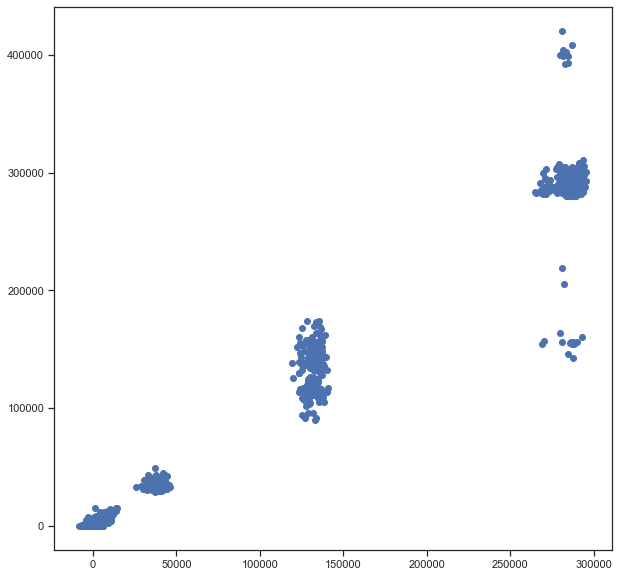

In [78]:
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(y_pred_xgb_20_80,Y_test_2080)

### Random Forrest

In [65]:
randomForrestPipe =  Pipeline([("scaler", StandardScaler()), ("rfr", RandomForestRegressor() )])

In [66]:
RF_grid_20_80= GridSearchCV(randomForrestPipe, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Fit the random search model
RF_grid_20_80.fit(X_train_2080, Y_train_2080)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.2min finished
D:\Anaconda\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rfr',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                    

In [70]:
y_pred_rf_20_80 =  evaluateModel(RF_grid_20_80.best_estimator_,X_train_2080,Y_train_2080,X_test_2080,Y_test_2080,'RandomForrest(20-80)train','RandomForrest(20-80)test')

D:\Anaconda\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


MAE-train 3030.73836689414
MAE-test 5111.551577365551
MAPE-train 53726.50825125248
MAPE-test 58425.8569312478
MSE-train 80006654.43759581
MSE-test 225491930.18404177
RMSE-train 8944.643896634221
RMSE-test 15016.38871979684


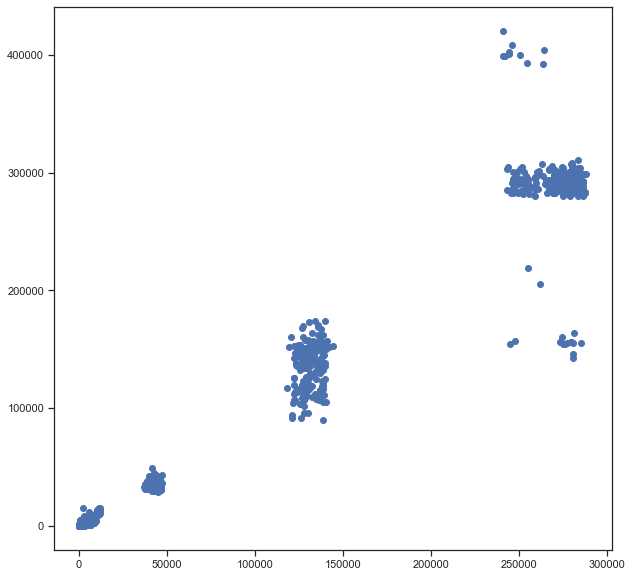

In [79]:
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(y_pred_rf_20_80,Y_test_2080)

### Statistics for 80% train 20% test split

In [54]:
# Splitting the data set into training : 20% and testing : 80% beacuse the dataset has covered the all the combinational space
X_train_8020,X_test_8020,Y_train_8020,Y_test_8020 = train_test_split(x_data,y_data,shuffle=True,train_size=0.8)

### XGBRegressor

In [55]:
XGB_grid_80_20 = GridSearchCV(XGBPipe, params,cv=5)
XGB_grid_80_20.fit(X_train_8020, Y_train_8020)

[13:34:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:35:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:35:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:35:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:36:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:36:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:36:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:36:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:37:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:37:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:37:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:37:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:37:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:37:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:37:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[13:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsample_bytree=1,
                                                     gamma=0,
                                                     importance_type='gain',
                                                     learning_rate=0.1,
                          

In [71]:
y_pred_xgb_80_20 =  evaluateModel(XGB_grid_80_20.best_estimator_,X_train_8020,Y_train_8020,X_test_8020,Y_test_8020,'XGBRegressor(80-20)train','XGBRegressor(80-20)test')

[13:47:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE-train 2856.503009446431
MAE-test 3245.2704430368417
MAPE-train 55432.290089857386
MAPE-test 72593.36622712025
MSE-train 105345410.4552182
MSE-test 146051106.12308192
RMSE-train 10263.791232055444
RMSE-test 12085.160574981282


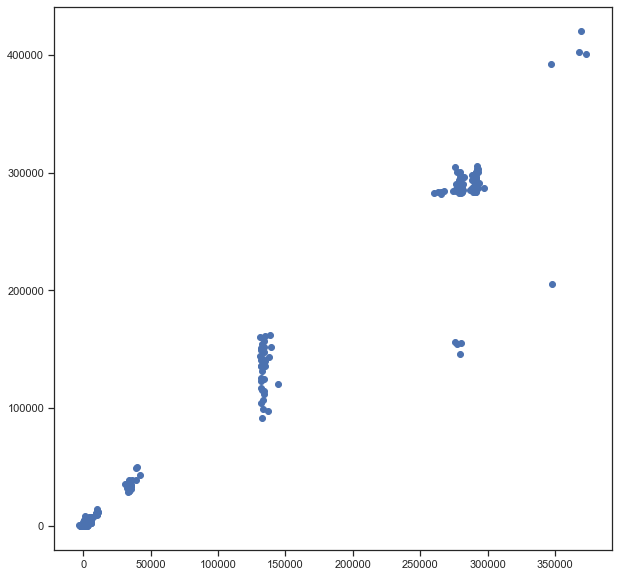

In [80]:
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(y_pred_xgb_80_20,Y_test_8020)

### RandomForrest

In [73]:
RF_grid_80_20 = GridSearchCV(randomForrestPipe, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Fit the random search model
RF_grid_80_20.fit(X_train_8020, Y_train_8020)
print("Best Parameters : ",RF_grid_80_20.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 454 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 737 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 1102 tasks      | elapsed:  1.2min


Best Parameters :  {'rfr__bootstrap': True, 'rfr__max_depth': 8, 'rfr__max_features': 'log2', 'rfr__min_samples_leaf': 3, 'rfr__min_samples_split': 10, 'rfr__n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.7min finished
D:\Anaconda\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [81]:
y_pred_rf_80_20 =  evaluateModel(RF_grid_80_20.best_estimator_,X_train_8020,Y_train_8020,X_test_8020,Y_test_8020,'RandomForrest(80-20)train','RandomForrest(80-20)test')

D:\Anaconda\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


MAE-train 3472.0855799534474
MAE-test 4075.613062533534
MAPE-train 55266.288859542394
MAPE-test 71938.92636073582
MSE-train 111212456.81094551
MSE-test 165349159.51552367
RMSE-train 10545.731686845893
RMSE-test 12858.816411922353


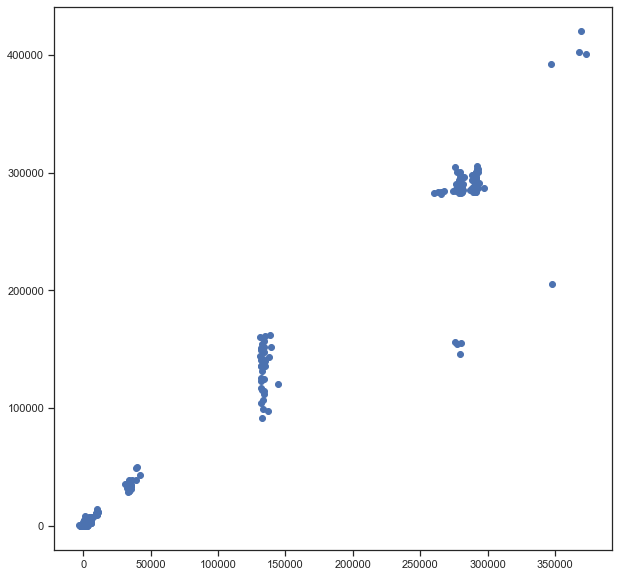

In [77]:
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(y_pred_rf_80_20,Y_test_8020)

#### Statistics

In [82]:
# Printing the statistics of above 20% 80% combination
pd.options.display.float_format = '{:,.3f}'.format
statistics

XGBRegressor(20-80)train  XGBRegressor(20-80)test  \
MAE                  2,767.397                3,910.039   
MAPE                54,834.473               60,007.013   
MSE             78,425,386.084          166,071,025.726   
RMSE                 8,855.811               12,886.855   

      XGBRegressor(80-20)train  XGBRegressor(80-20)test  \
MAE                  2,856.503                3,245.270   
MAPE                55,432.290               72,593.366   
MSE            105,345,410.455          146,051,106.123   
RMSE                10,263.791               12,085.161   

      RandomForrest(20-80)train  RandomForrest(20-80)test  \
MAE                   3,030.738                 5,111.552   
MAPE                 53,726.508                58,425.857   
MSE              80,006,654.438           225,491,930.184   
RMSE                  8,944.644                15,016.389   

      RandomForrest(80-20)train  RandomForrest(80-20)test  
MAE                   3,472.086                 4,075.613  
MAPE                 55,266.289                71,938.926  
MSE             111,212,456.811           165,349,159.516  
RMSE                 10,545.732                12,858.816

## Analyzing for each benchmark application

In [ ]:
statisticsReocrds = {
    'Ferret-XGBRegressor-train':[0.0, 0.0, 0.0, 0.0,0.0],
    'Ferret-XGBRegressor-test':[0.0, 0.0, 0.0, 0.0,0.0],
    'Ferret-RandomForrest-train':[0.0, 0.0, 0.0, 0.0,0.0],
    'Ferret-RandomForrest-test':[0.0, 0.0, 0.0, 0.0,0.0],
    'Dedup-XGBRegressor-train':[0.0, 0.0, 0.0, 0.0,0.0],
    'Dedup-XGBRegressor-test':[0.0, 0.0, 0.0, 0.0,0.0],
    'Dedup-RandomForrest-train':[0.0, 0.0, 0.0, 0.0,0.0],
    'Dedup-RandomForrest-test':[0.0, 0.0, 0.0, 0.0,0.0],
    'X264-XGBRegressor-train':[0.0, 0.0, 0.0, 0.0,0.0],
    'X264-XGBRegressor-test':[0.0, 0.0, 0.0, 0.0,0.0],
    'X264-RandomForrest-train':[0.0, 0.0, 0.0, 0.0,0.0]} 
    'X264-RandomForrest-test':[0.0, 0.0, 0.0, 0.0,0.0]} 
  
# Creates pandas DataFrame. 
applicationWiseStatistics = pd.DataFrame(statisticsReocrds, index =['r2score', 'MAE', 'MAPE', 'MSE','RMSE']) 
applicationWiseStatistics

### Ferret

In [ ]:
columns = ['name','input','compiler','threads','cores','real']
ferretData = ferretData[columns]
ferretData = ferretData.loc[ferretData['name'] == "ferret"]
ferretData = pd.get_dummies(ferretData)

In [ ]:
y_data = ferretData.iloc[:,2:3]
x_data = ferretData.drop(['real'],axis=1)

In [ ]:
# Splitting the data set into training : 20% and testing : 80% beacuse the dataset has covered the all the combinational space
X_train,X_test,Y_train,Y_test = train_test_split(x_data,y_data,shuffle=True,train_size=0.8)

#### XGBRegressor

In [ ]:
grid = GridSearchCV(XGBPipe, params,cv=5)
grid.fit(X_train, Y_train)

In [ ]:
xgb_best = XGBRegressor(**grid.best_params_)

evaluateModel(xgb_best,X_train,Y_trai,X_test,Y_test,'Ferret-XGBRegressor')

#### RandomForrest

In [ ]:
grid_search = GridSearchCV(randomForrestPipe, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Fit the random search model
grid_search.fit(X_train, Y_train)
print("Best Parameters : ",grid_search.best_params_)
print("Best Score : ",grid_search.best_score_)

In [ ]:
best_rf =grid_search.best_estimator_

#Print r2 score
r2score = r2_score(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['Ferret-RandomForrest'].r2score = r2score
print("R2 score",r2score)

#Print MAE
mae = mean_absolute_error(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['Ferret-RandomForrest'].MAE = mae
print('MAE : ',mae)

#Print MAPE
mape = mean_absolute_percentage_error(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['Ferret-RandomForrest'].MAPE = mape
print('MAPE : ',mape)

#Print MSE
mse = mean_squared_error(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['Ferret-RandomForrest'].MSE = mse
print('MSE : ',mse)

#Print RMSE
rmse = math.sqrt(mean_squared_error(Y_test, best_rf.predict(X_test)))
applicationWiseStatistics['Ferret-RandomForrest'].RMSE = rmse
print('MSE : ',rmse)

### Dedup

In [ ]:
columns = ['name','input','compiler','threads','cores','real']
dedupDataupData = dedupData[columns]
dedupData = dedupData.loc[dedupData['name'] == "dedup"]
dedupData = pd.get_dummies(dedupData)

In [ ]:
y_data = dedupData.iloc[:,2:3]
x_data = dedupData.drop(['real'],axis=1)

In [ ]:
# Splitting the data set into training : 20% and testing : 80% beacuse the dataset has covered the all the combinational space
X_train,X_test,Y_train,Y_test = train_test_split(x_data,y_data,shuffle=True,train_size=0.8)

#### XGBRegressor

In [ ]:
grid = GridSearchCV(XGBPipe, params,cv=5)
grid.fit(X_train, Y_train)

In [ ]:
bestParams  = grid.best_params_
print('Best Params : ',grid.best_params_)
print('Best Params : ',grid.best_score_)

# Print the r2 score
print(r2_score(Y_test, grid.best_estimator_.predict(X_test)))

#Print MAE
print('MAE : ',mean_absolute_error(Y_test, grid.best_estimator_.predict(X_test)))


In [ ]:
xgb_best = XGBRegressor(**grid.best_params_)
xgb_best.fit(X_train,Y_train)

#Print r2 Score
r2score = r2_score(Y_test, xgb_best.predict(X_test))
print("R2 score",r2score)
applicationWiseStatistics['Dedup-XGBRegressor'].r2score = r2score

#Print MAE
mae = mean_absolute_error(Y_test, xgb_best.predict(X_test))
applicationWiseStatistics['Dedup-XGBRegressor'].MAE = mae

print('MAE : ',mae)

#Print MAPE
mape = mean_absolute_percentage_error(Y_test, xgb_best.predict(X_test))
applicationWiseStatistics['Dedup-XGBRegressor'].MAPE = mape
print('MAPE : ',mape)

#Print MSE
mse = mean_squared_error(Y_test, xgb_best.predict(X_test))
applicationWiseStatistics['Dedup-XGBRegressor'].MSE = mse
print('MSE : ',mse)

#Print RMSE
rmse = math.sqrt(mean_squared_error(Y_test, xgb_best.predict(X_test)))
applicationWiseStatistics['Dedup-XGBRegressor'].RMSE = rmse
print('RMSE : ',rmse)

#### RandomForrest

In [ ]:
grid_search = GridSearchCV(randomForrestPipe, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Fit the random search model
grid_search.fit(X_train, Y_train)
print("Best Parameters : ",grid_search.best_params_)
print("Best Score : ",grid_search.best_score_)

In [ ]:
best_rf =grid_search.best_estimator_

#Print r2 score
r2score = r2_score(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['Dedup-RandomForrest'].r2score = r2score
print("R2 score",r2score)

#Print MAE
mae = mean_absolute_error(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['Dedup-RandomForrest'].MAE = mae
print('MAE : ',mae)

#Print MAPE
mape = mean_absolute_percentage_error(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['Dedup-RandomForrest'].MAPE = mape
print('MAPE : ',mape)

#Print MSE
mse = mean_squared_error(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['Dedup-RandomForrest'].MSE = mse
print('MSE : ',mse)

#Print RMSE
rmse = math.sqrt(mean_squared_error(Y_test, best_rf.predict(X_test)))
applicationWiseStatistics['Dedup-RandomForrest'].RMSE = rmse
print('MSE : ',rmse)

### x264

In [ ]:
columns = ['name','input','compiler','threads','cores','real']
x264Data = x264Data[columns]
x264Data = x264Data.loc[x264Data['name'] == "x264"]
x264Data = pd.get_dummies(x264Data)

In [ ]:
y_data = x264Data.iloc[:,2:3]
x_data = x264Data.drop(['real'],axis=1)

In [ ]:
# Splitting the data set into training : 20% and testing : 80% beacuse the dataset has covered the all the combinational space
X_train,X_test,Y_train,Y_test = train_test_split(x_data,y_data,shuffle=True,train_size=0.8)

#### XGBRegressor

In [ ]:
grid = GridSearchCV(XGBPipe, params,cv=5)
grid.fit(X_train, Y_train)

In [ ]:
bestParams  = grid.best_params_
print('Best Params : ',grid.best_params_)
print('Best Params : ',grid.best_score_)

# Print the r2 score
print(r2_score(Y_test, grid.best_estimator_.predict(X_test)))

#Print MAE
print('MAE : ',mean_absolute_error(Y_test, grid.best_estimator_.predict(X_test)))


In [ ]:
xgb_best = XGBRegressor(**grid.best_params_)
xgb_best.fit(X_train,Y_train)

#Print r2 Score
r2score = r2_score(Y_test, xgb_best.predict(X_test))
print("R2 score",r2score)
applicationWiseStatistics['X264-XGBRegressor'].r2score = r2score

#Print MAE
mae = mean_absolute_error(Y_test, xgb_best.predict(X_test))
applicationWiseStatistics['X264-XGBRegressor'].MAE = mae

print('MAE : ',mae)

#Print MAPE
mape = mean_absolute_percentage_error(Y_test, xgb_best.predict(X_test))
applicationWiseStatistics['X264-XGBRegressor'].MAPE = mape
print('MAPE : ',mape)

#Print MSE
mse = mean_squared_error(Y_test, xgb_best.predict(X_test))
applicationWiseStatistics['X264-XGBRegressor'].MSE = mse
print('MSE : ',mse)

#Print RMSE
rmse = math.sqrt(mean_squared_error(Y_test, xgb_best.predict(X_test)))
applicationWiseStatistics['X264-XGBRegressor'].RMSE = rmse
print('RMSE : ',rmse)

#### RandomForrest

In [ ]:
grid_search = GridSearchCV(randomForrestPipe, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Fit the random search model
grid_search.fit(X_train, Y_train)
print("Best Parameters : ",grid_search.best_params_)
print("Best Score : ",grid_search.best_score_)

In [ ]:
best_rf =grid_search.best_estimator_

#Print r2 score
r2score = r2_score(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['X264-RandomForrest'].r2score = r2score
print("R2 score",r2score)

#Print MAE
mae = mean_absolute_error(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['X264-RandomForrest'].MAE = mae
print('MAE : ',mae)

#Print MAPE
mape = mean_absolute_percentage_error(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['X264-RandomForrest'].MAPE = mape
print('MAPE : ',mape)

#Print MSE
mse = mean_squared_error(Y_test, best_rf.predict(X_test))
applicationWiseStatistics['X264-RandomForrest'].MSE = mse
print('MSE : ',mse)

#Print RMSE
rmse = math.sqrt(mean_squared_error(Y_test, best_rf.predict(X_test)))
applicationWiseStatistics['X264-RandomForrest'].RMSE = rmse
print('MSE : ',rmse)

#### Application wise Statistics

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format
applicationWiseStatistics


# Model Evaluation

In [ ]:
list_of_tuples = list(zip(Y_test_2080['real'],y_pred_xgb_20_80,y_pred_rf_20_80))  
    
# Converting lists of tuples into  
# pandas Dataframe.  
df = pd.DataFrame(list_of_tuples, columns = ['Y Actual (20/80)', 'y_pred_xgb_20_80',"y_pred_rf_20_80"])  
df.to_csv('predictions-2080.csv') 
  
# Print data.  
df  


In [ ]:
list_of_tuples = list(zip(Y_test_8020['real'],y_pred_xgb_80_20,y_pred_rf_80_20))  
    
# Converting lists of tuples into  
# pandas Dataframe.  
df = pd.DataFrame(list_of_tuples, columns = ["Y Actual (80/20)","y_pred_xgb_80_20","y_pred_rf_80_20"])  
df.to_csv('predictions-8020.csv') 
# Print data.  
df  


In [ ]:
Y_test_2080['real'].value_counts()